In [1]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as n
import cv2
import os

opj = os.path.join

%matplotlib inline

## Code below serves as full pipeline for advanced lane finding

## Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


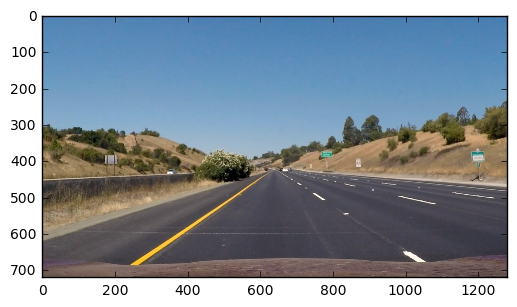

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Camera Calibration

In [3]:
def calibrate_camera(cam_cali_dir, num_corners=(9,6)):

    # to store object and image objects
    objpoints = []
    imgpoints = []

    # object points if possible
    num_obj_w = num_corners[0]
    num_obj_h = num_corners[1]
    objp = n.zeros((num_obj_w*num_obj_h, 3), n.float32)
    objp[:,:2] = n.mgrid[0:num_obj_w,0:num_obj_h].T.reshape(-1,2) # x, y coordinates

    for fname in os.listdir(cam_cali_dir):
        img = mpimg.imread(opj(cam_cali_dir, fname))

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find corners on the chessboard
        ret, corners = cv2.findChessboardCorners(gray, (num_obj_w, num_obj_h), None)

        # if corners found, add object points and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (num_obj_w, num_obj_h), corners, ret)
    return objpoints, imgpoints

In [4]:
cam_cali_dir = 'camera_cal/'
objpoints, imgpoints = calibrate_camera(cam_cali_dir, num_corners=(9,6))

## Correct for distortion

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)

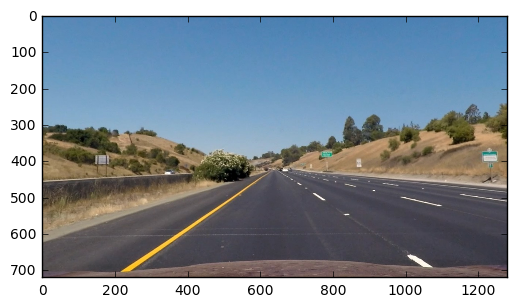

In [7]:
plt.imshow(undist_image)

## Color and Gradient threshold

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = n.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = n.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = n.uint8(255*abs_sobel/n.max(abs_sobel))
    grad_binary = n.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = n.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = n.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(n.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = n.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, n.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = n.arctan2(n.absolute(sobely), n.absolute(sobelx))
    dir_binary =  n.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = n.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def grad_threshold(img, ksize=11, do_plot=True):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(n.pi/6, n.pi/3))
    s_binary = hls_select(img, thresh=(170, 255))
    
    # did NOT use gradient directions
    grad_img = s_binary | gradx
    
    if do_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(img, cmap='gray')
        ax.set_title('before gradient thresholding')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(grad_img, cmap='gray')
        ax.set_title('after gradient thresholding')
        plt.show()
    return grad_img

def crop_roi(img, vertices, do_plot=True):
    ignore_mask_color = 255
    mask = n.zeros_like(img)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(img, mask)
    if do_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(masked, cmap='gray')
        ax.set_title('after masking ROI')
        plt.show()
    return masked

def masked_grad_image(images, do_plot=True):
    masked_grad_images = []
    for image in images:
        grad_image = grad_threshold(image, do_plot=do_plot)
        h, w = grad_image.shape[:2]
        h_offset = 50

        # get ROI
        lower_left = (100, h - h_offset)
        upper_left = (550, 420)
        upper_right = (666, 420)
        lower_right = (1200, h - h_offset)
        vertices = n.array([[lower_left, upper_left, upper_right, lower_right]], dtype=n.int32)

        # crop ROI
        masked_grad_image = crop_roi(grad_image, vertices, do_plot=do_plot)
        masked_grad_images.append(masked_grad_image)
    return masked_grad_images

In [9]:
images = []
for fname in os.listdir('test_images/'):
    image = mpimg.imread(opj('test_images/', fname))
    undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)
    images.append(undist_image)

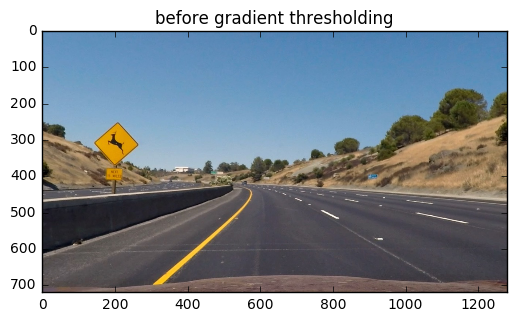

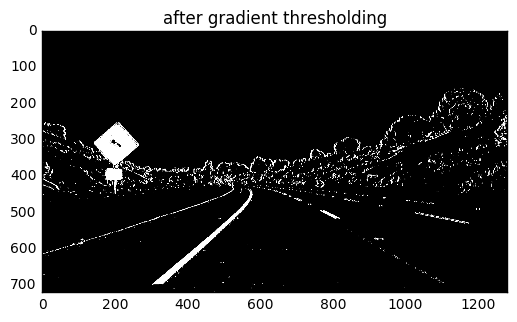

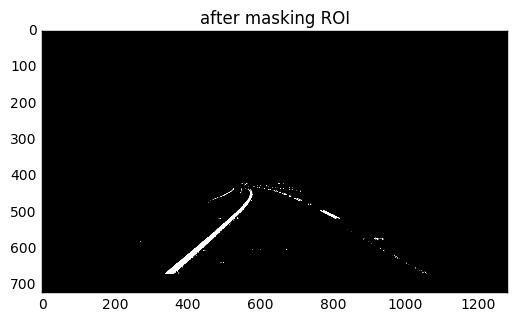

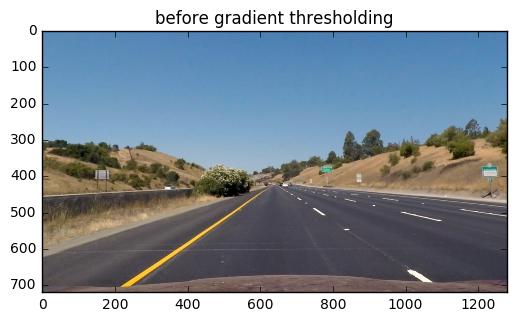

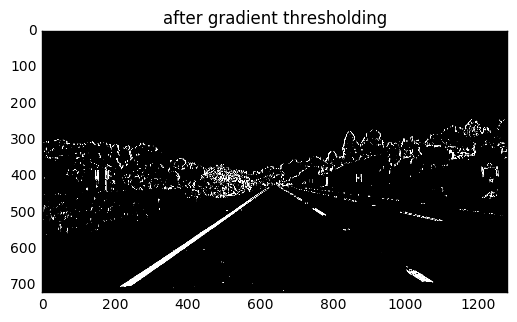

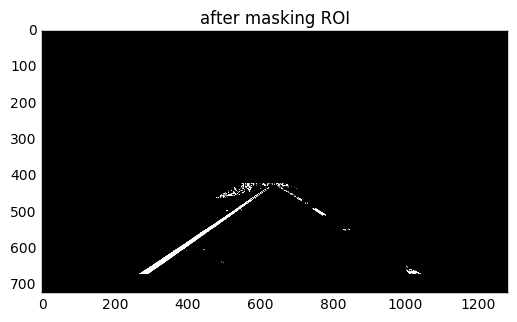

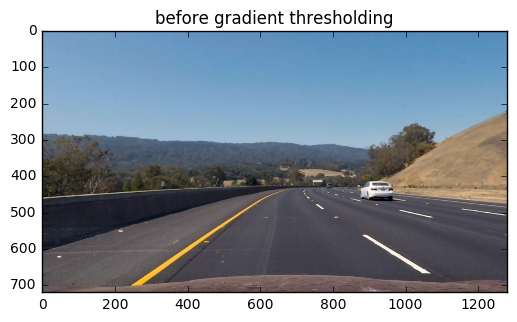

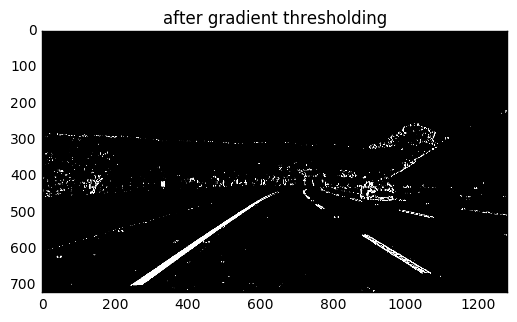

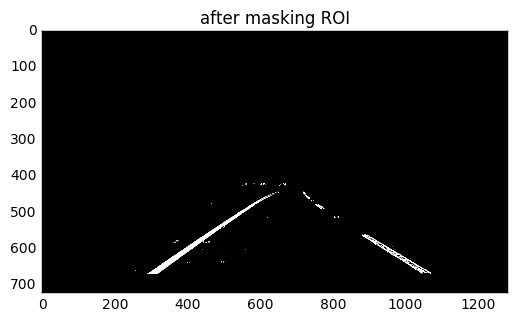

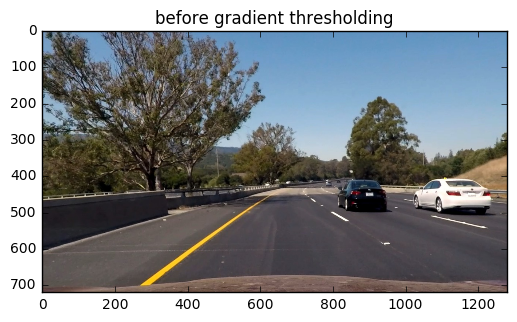

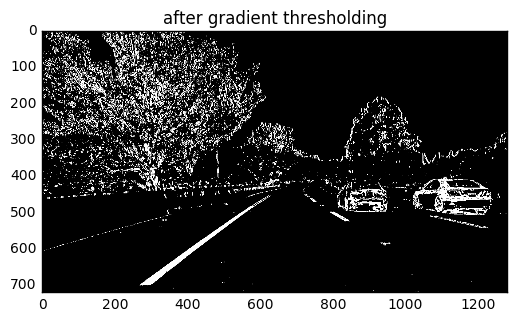

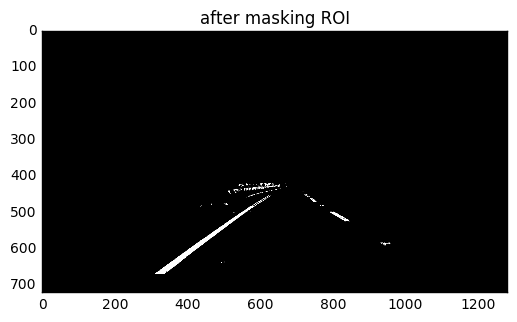

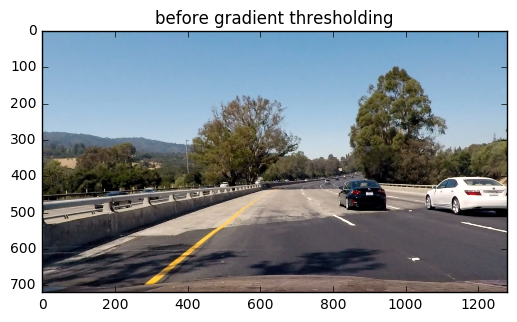

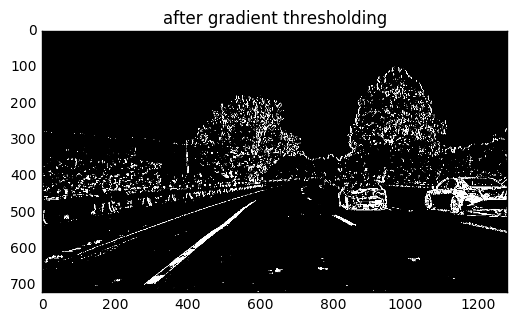

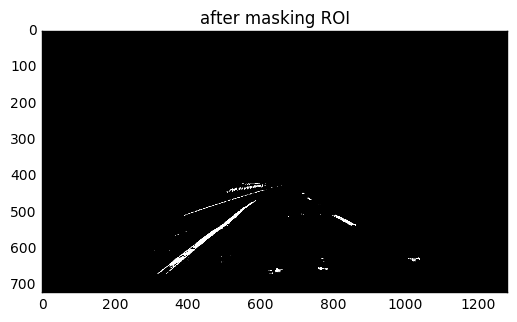

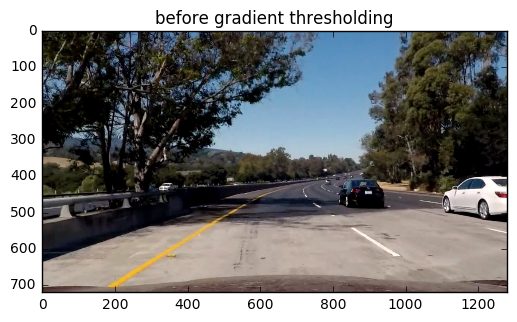

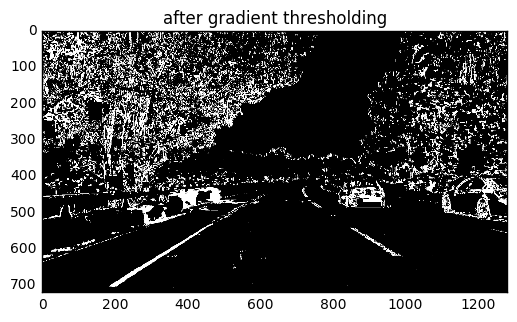

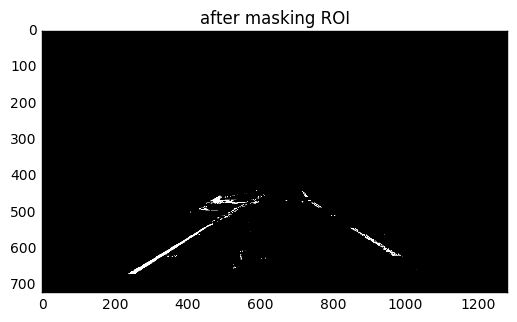

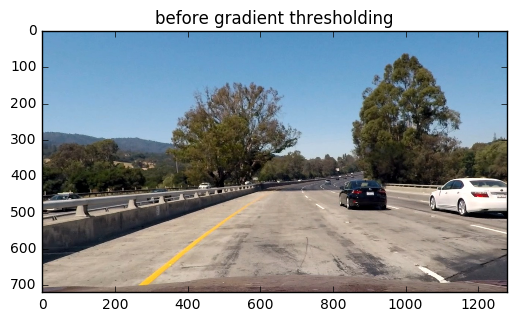

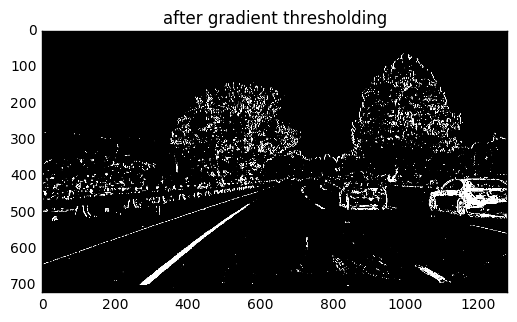

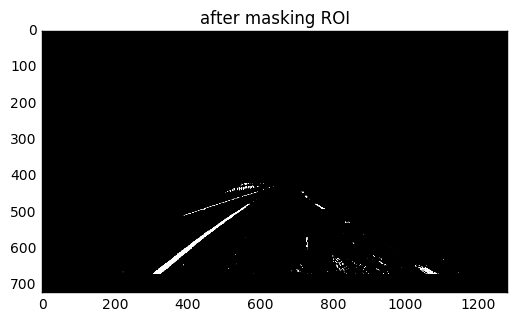

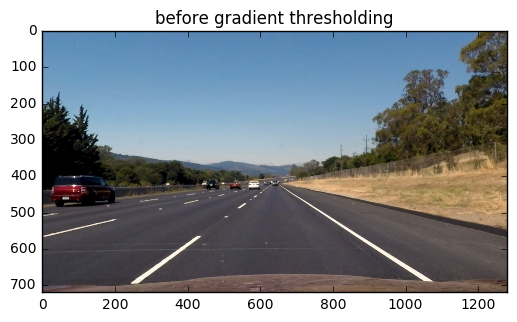

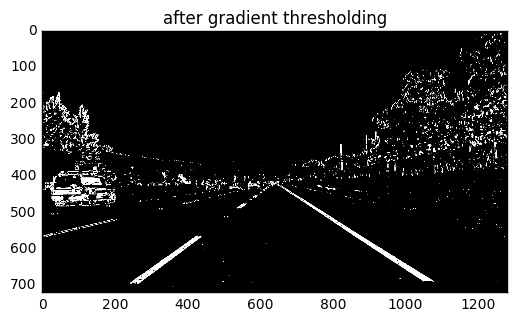

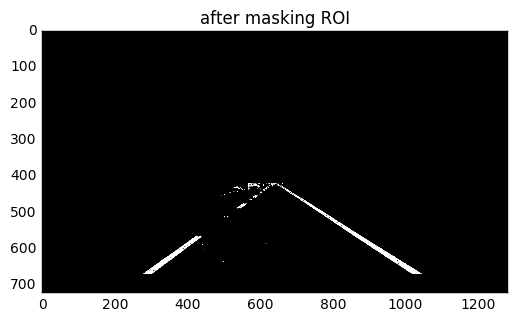

In [11]:
masked_grad_images = masked_grad_image(images, do_plot=True)

## Apply perspective transform

In [12]:
def apply_perspective_transform(undist, src, dst, do_plot=True, cmap='gray', return_M=False):
    img_size = undist.shape[1], undist.shape[0]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    if do_plot:
        undist_cp = undist.copy()
        warped_cp = warped.copy()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cv2.polylines(undist_cp,n.int32([src]),True,(0,255,255),10)
        ax.imshow(undist_cp, cmap=cmap)
        ax.set_title('img before perspective transform')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cv2.polylines(warped_cp,n.int32([dst]),True,(0,255,255),10)
        ax.imshow(warped_cp, cmap=cmap)
        ax.set_title('img after perspective transform')
    if return_M:
        return warped, M, Minv
    else:
        return warped

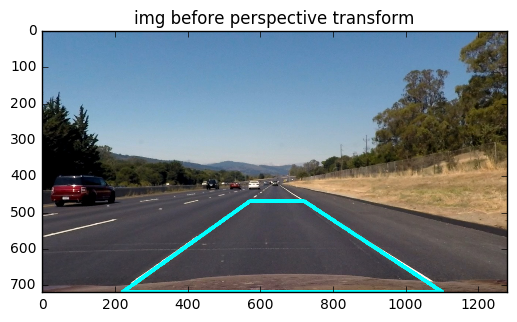

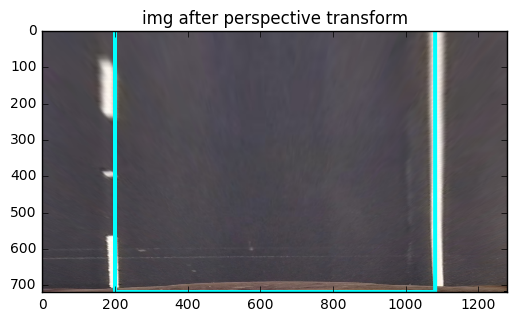

In [13]:
src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
dst = n.array([[200,720], [200,0], [1080,0], [1080,720]], dtype=n.float32)
warped = apply_perspective_transform(undist_image, src, dst, do_plot=True)

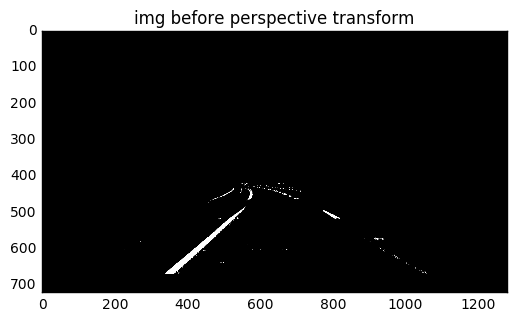

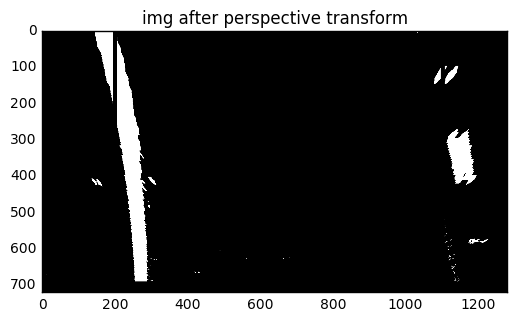

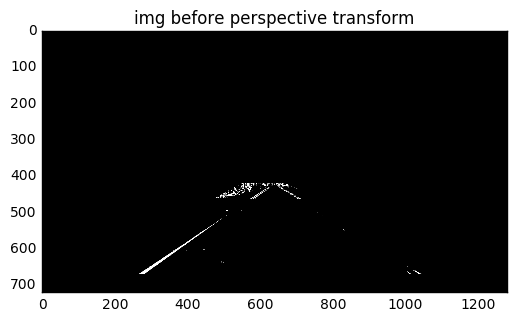

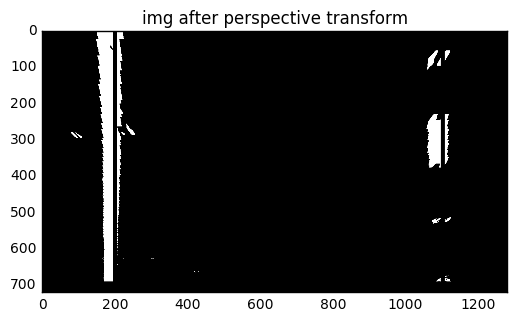

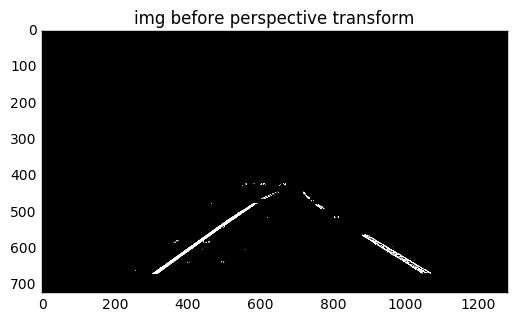

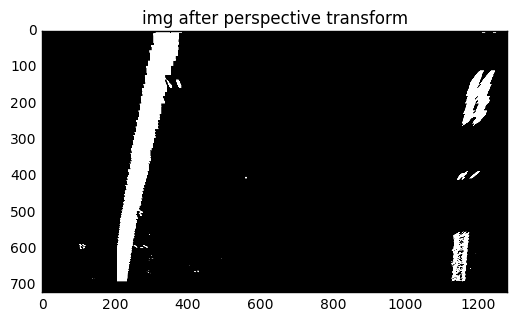

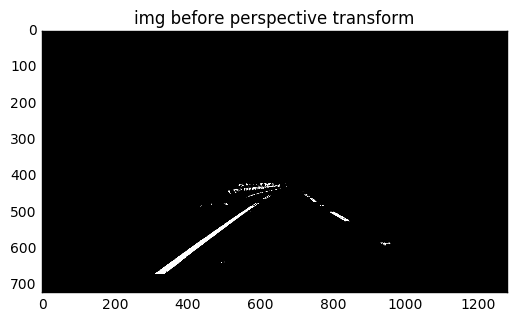

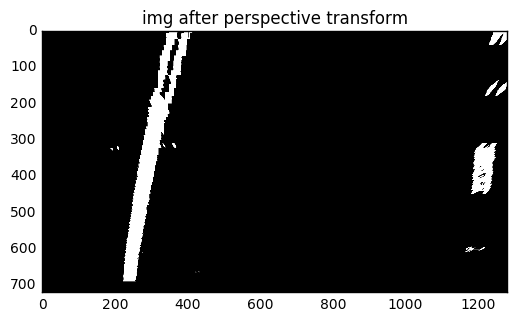

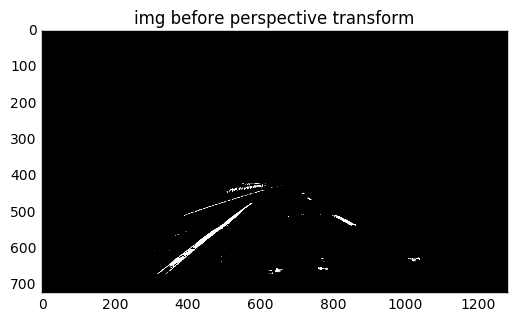

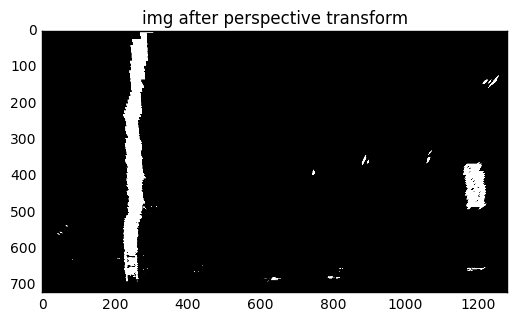

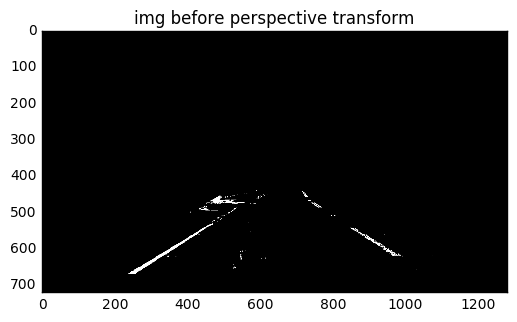

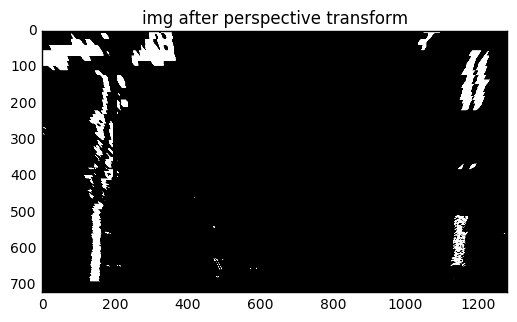

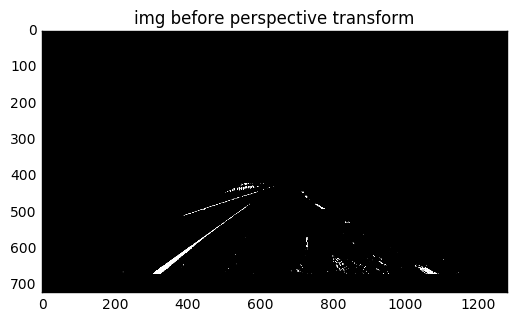

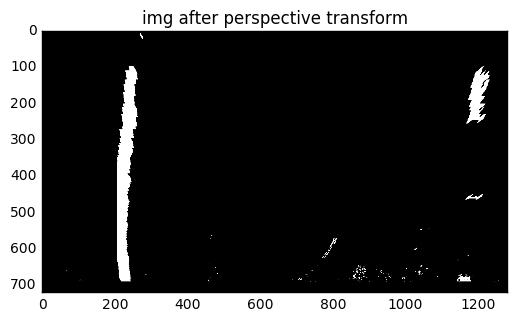

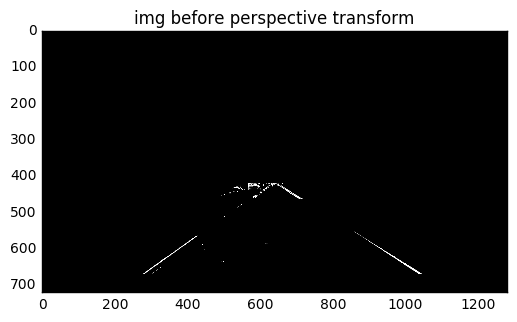

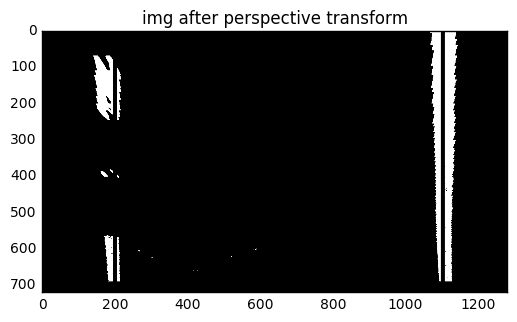

In [14]:
images = []
src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
dst = n.array([[200,720], [200,0], [1100,0], [1100,720]], dtype=n.float32)
for image in masked_grad_images:
    warped = apply_perspective_transform(image, src, dst, do_plot=True)
    images.append(warped)

## Find the lines

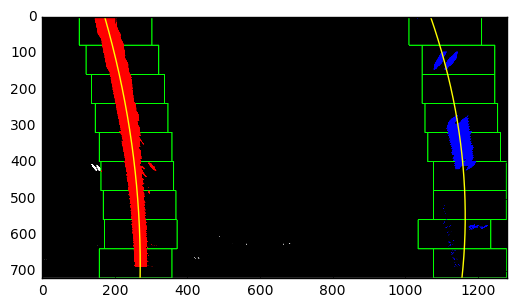

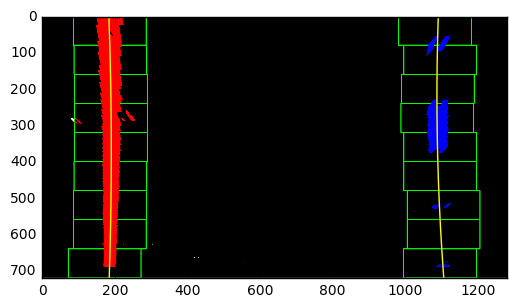

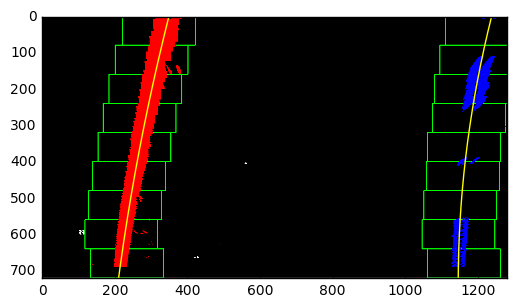

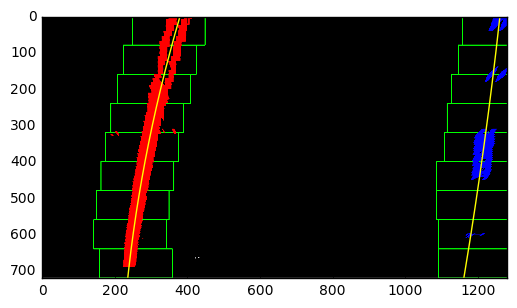

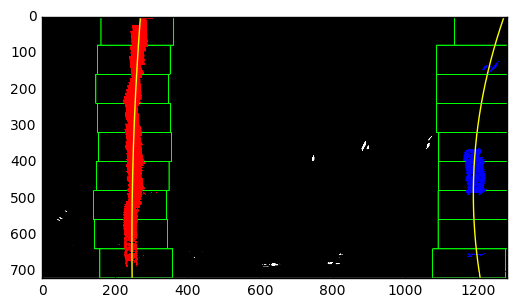

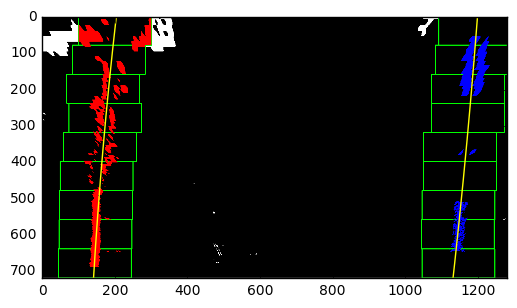

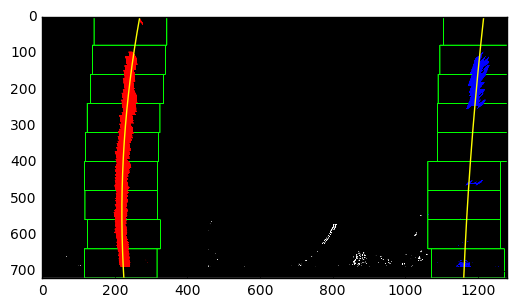

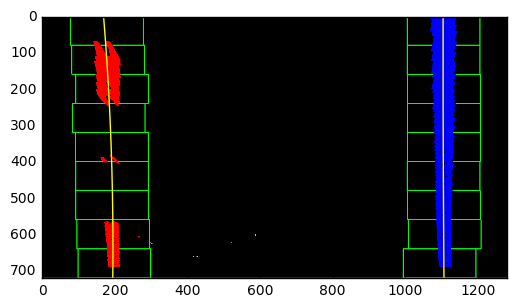

In [33]:
for binary_warped in images:
    histogram = n.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = n.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = n.int(histogram.shape[0]//2)
    leftx_base = n.argmax(histogram[:midpoint])
    rightx_base = n.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = n.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = n.array(nonzero[0])
    nonzerox = n.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = n.int(n.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = n.int(n.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = n.concatenate(left_lane_inds)
    right_lane_inds = n.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = n.polyfit(lefty, leftx, 2)
    right_fit = n.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = n.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    y_eval = n.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

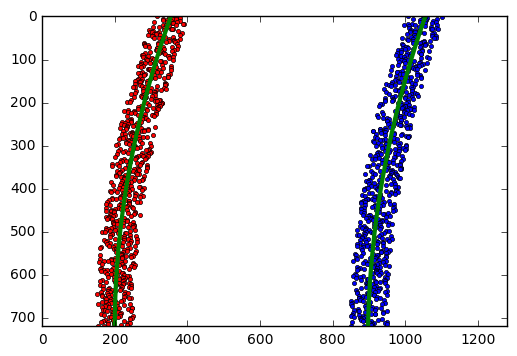

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = n.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = n.array([200 + (y**2)*quadratic_coeff + n.random.randint(-50, high=51) 
                              for y in ploty])
rightx = n.array([900 + (y**2)*quadratic_coeff + n.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = n.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = n.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

## Full pipeline

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class MyVideoProcessor(object):

    # constructor function
    def __init__(self):
        # store past frames
        self.left_fit = None
        self.right_fit = None

    def pipeline_function(self, image):
        # correct for distortion
        undist_image = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)

        # apply gradient and color threshold
        grad_image = grad_threshold(undist_image, do_plot=do_plot)
        h, w = grad_image.shape[:2]
        h_offset = 50

        # get ROI
        lower_left = (100, h - h_offset)
        upper_left = (550, 420)
        upper_right = (666, 420)
        lower_right = (1200, h - h_offset)
        vertices = n.array([[lower_left, upper_left, upper_right, lower_right]], dtype=n.int32)
        masked_grad_image = crop_roi(grad_image, vertices, do_plot=do_plot)

        # apply perspective transform
        src = n.array([[220, 720], [570, 470], [720, 470], [1100, 720]], dtype=n.float32)
        dst = n.array([[200,720], [200,0], [1080,0], [1080,720]], dtype=n.float32)
        binary_warped, M, Minv = apply_perspective_transform(masked_grad_image, src, dst, do_plot=do_plot, return_M=True)

        # find lines and fit second order polynomial
        histogram = n.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = n.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = n.int(histogram.shape[0]//2)
        leftx_base = n.argmax(histogram[:midpoint])
        rightx_base = n.argmax(histogram[midpoint:]) + midpoint
        
        if self.left_fit is None:
            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = n.int(binary_warped.shape[0]//nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = n.array(nonzero[0])
            nonzerox = n.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = n.int(n.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = n.int(n.mean(nonzerox[good_right_inds]))        

            # Concatenate the arrays of indices
            left_lane_inds = n.concatenate(left_lane_inds)
            right_lane_inds = n.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Fit a second order polynomial to each
            left_fit = n.polyfit(lefty, leftx, 2)
            right_fit = n.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = n.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            self.left_fit = left_fit
            self.right_fit = right_fit
        else:
            left_fit = self.left_fit
            right_fit = self.right_fit

            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            self.left_fit = left_fit
            self.right_fit = right_fit

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 20/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/900 # meters per pixel in x dimension

        offset = ((left_fitx[-1] + right_fitx[-1]) * 0.5 - midpoint) * xm_per_pix

        # Fit new polynomials to x,y in world space
        left_fit_cr = n.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = n.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / n.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / n.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m

        # Create an image to draw the lines on
        warp_zero = n.zeros_like(binary_warped).astype(n.uint8)
        color_warp = n.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = n.array([n.transpose(n.vstack([left_fitx, ploty]))])
        pts_right = n.array([n.flipud(n.transpose(n.vstack([right_fitx, ploty])))])
        pts = n.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, n.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,'Left lane curvature: ' + str(left_curverad) + 'm',(10,50), font, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'Right lane curvature: ' + str(right_curverad) + 'm',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'Position: ' + str(offset) + 'm',(10,150), font, 2,(255,255,255),2,cv2.LINE_AA)
        return result

In [34]:
my_video_processor_object = MyVideoProcessor()

output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline_function)

%time white_clip.write_videofile(output, audio=False)

545.94652975 m 851.919404783 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:01<27:25,  1.31s/it]

551.180210488 m 851.919404783 m






  0%|          | 2/1261 [00:02<26:27,  1.26s/it]

496.27243089 m 1791.24104369 m






  0%|          | 3/1261 [00:03<26:00,  1.24s/it]

488.165216062 m 1733.74126361 m






  0%|          | 4/1261 [00:04<25:37,  1.22s/it]

438.554114295 m 1548.15044504 m






  0%|          | 5/1261 [00:06<25:34,  1.22s/it]

440.509380515 m 478.28525445 m






  0%|          | 6/1261 [00:07<25:21,  1.21s/it]

444.831560544 m 603.479553871 m






  1%|          | 7/1261 [00:08<25:06,  1.20s/it]

436.284788043 m 594.144013414 m






  1%|          | 8/1261 [00:09<24:51,  1.19s/it]

445.718279813 m 708.067704433 m






  1%|          | 9/1261 [00:10<25:10,  1.21s/it]

454.543328449 m 379.062717831 m






  1%|          | 10/1261 [00:12<25:40,  1.23s/it]

445.182316465 m 379.388804273 m






  1%|          | 11/1261 [00:13<25:06,  1.21s/it]

453.437875217 m 496.427522947 m






  1%|          | 12/1261 [00:14<24:55,  1.20s/it]

496.885511375 m 623.612425151 m






  1%|          | 13/1261 [00:15<24:37,  1.18s/it]

490.652989229 m 1487.19371083 m






  1%|          | 14/1261 [00:16<24:20,  1.17s/it]

480.803494517 m 9125.8502293 m






  1%|          | 15/1261 [00:18<24:59,  1.20s/it]

507.296897423 m 1950.74179482 m






  1%|▏         | 16/1261 [00:19<24:48,  1.20s/it]

597.322282689 m 2218.75728077 m






  1%|▏         | 17/1261 [00:20<25:20,  1.22s/it]

625.994445398 m 1300.48847076 m






  1%|▏         | 18/1261 [00:21<25:23,  1.23s/it]

705.375699419 m 1680.87002677 m






  2%|▏         | 19/1261 [00:22<24:59,  1.21s/it]

724.349181282 m 2592.52545043 m






  2%|▏         | 20/1261 [00:24<24:28,  1.18s/it]

848.517516192 m 1588.99072705 m






  2%|▏         | 21/1261 [00:25<24:26,  1.18s/it]

1053.73809939 m 1771.96976715 m






  2%|▏         | 22/1261 [00:26<24:30,  1.19s/it]

1161.55273314 m 723.62034078 m






  2%|▏         | 23/1261 [00:27<24:15,  1.18s/it]

1513.46733015 m 338.26036278 m






  2%|▏         | 24/1261 [00:28<24:27,  1.19s/it]

1294.86708985 m 434.376736923 m






  2%|▏         | 25/1261 [00:29<24:04,  1.17s/it]

1009.24184263 m 425.978478296 m






  2%|▏         | 26/1261 [00:31<24:00,  1.17s/it]

1181.95923185 m 494.00678407 m






  2%|▏         | 27/1261 [00:32<24:33,  1.19s/it]

937.503287884 m 987.968540069 m






  2%|▏         | 28/1261 [00:33<24:16,  1.18s/it]

847.541203084 m 1180.37480497 m






  2%|▏         | 29/1261 [00:34<24:04,  1.17s/it]

781.392043472 m 1622.16149863 m






  2%|▏         | 30/1261 [00:35<23:53,  1.16s/it]

625.099997833 m 1246.98048503 m






  2%|▏         | 31/1261 [00:36<23:39,  1.15s/it]

561.161144057 m 587.407124299 m






  3%|▎         | 32/1261 [00:38<23:59,  1.17s/it]

493.636179663 m 616.948612013 m






  3%|▎         | 33/1261 [00:39<23:50,  1.16s/it]

486.328246253 m 802.417682934 m






  3%|▎         | 34/1261 [00:40<24:35,  1.20s/it]

480.236288609 m 577.311080975 m






  3%|▎         | 35/1261 [00:41<25:06,  1.23s/it]

518.286634059 m 313.583852665 m






  3%|▎         | 36/1261 [00:43<25:01,  1.23s/it]

473.178542127 m 437.021274916 m






  3%|▎         | 37/1261 [00:44<24:30,  1.20s/it]

467.785913119 m 472.542593938 m






  3%|▎         | 38/1261 [00:45<24:47,  1.22s/it]

434.904181167 m 608.791888976 m






  3%|▎         | 39/1261 [00:46<24:34,  1.21s/it]

404.818244264 m 1293.05351258 m






  3%|▎         | 40/1261 [00:47<24:36,  1.21s/it]

393.840242633 m 898.710487693 m






  3%|▎         | 41/1261 [00:49<24:59,  1.23s/it]

391.196391914 m 1297.2494855 m






  3%|▎         | 42/1261 [00:50<25:42,  1.26s/it]

381.088335692 m 713.354791277 m






  3%|▎         | 43/1261 [00:51<25:18,  1.25s/it]

373.79829921 m 589.020692863 m






  3%|▎         | 44/1261 [00:52<25:05,  1.24s/it]

371.872332828 m 745.503824804 m






  4%|▎         | 45/1261 [00:54<25:23,  1.25s/it]

377.966204863 m 711.558492534 m






  4%|▎         | 46/1261 [00:55<24:52,  1.23s/it]

373.270822054 m 553.391129669 m






  4%|▎         | 47/1261 [00:56<24:20,  1.20s/it]

375.01267123 m 440.796077545 m






  4%|▍         | 48/1261 [00:57<24:02,  1.19s/it]

396.160119702 m 324.251862708 m






  4%|▍         | 49/1261 [00:58<24:36,  1.22s/it]

409.404671566 m 378.461399239 m






  4%|▍         | 50/1261 [01:00<24:49,  1.23s/it]

387.600838645 m 425.057240936 m






  4%|▍         | 51/1261 [01:01<24:23,  1.21s/it]

417.76048088 m 515.694623751 m






  4%|▍         | 52/1261 [01:02<24:04,  1.19s/it]

431.828436636 m 1875.75650425 m






  4%|▍         | 53/1261 [01:03<23:59,  1.19s/it]

509.701321887 m 1021.30060871 m






  4%|▍         | 54/1261 [01:04<23:39,  1.18s/it]

541.987501663 m 826.01017715 m






  4%|▍         | 55/1261 [01:05<23:23,  1.16s/it]

604.177632685 m 489.556578873 m






  4%|▍         | 56/1261 [01:07<23:54,  1.19s/it]

756.79801878 m 644.079384941 m






  5%|▍         | 57/1261 [01:08<23:32,  1.17s/it]

840.496378873 m 723.681706522 m






  5%|▍         | 58/1261 [01:09<23:25,  1.17s/it]

910.494418876 m 814.016209545 m






  5%|▍         | 59/1261 [01:10<23:17,  1.16s/it]

1125.59677254 m 293.241571562 m






  5%|▍         | 60/1261 [01:11<23:16,  1.16s/it]

1209.60503967 m 357.052098452 m






  5%|▍         | 61/1261 [01:12<23:15,  1.16s/it]

1077.35765448 m 438.225209357 m






  5%|▍         | 62/1261 [01:14<23:27,  1.17s/it]

1029.51852406 m 689.157240346 m






  5%|▍         | 63/1261 [01:15<23:10,  1.16s/it]

917.816257943 m 4398.6802349 m






  5%|▌         | 64/1261 [01:16<22:58,  1.15s/it]

751.177815963 m 1872.30986863 m






  5%|▌         | 65/1261 [01:17<22:58,  1.15s/it]

684.765830651 m 1279.09625057 m






  5%|▌         | 66/1261 [01:18<22:49,  1.15s/it]

548.576008392 m 669.85637676 m






  5%|▌         | 67/1261 [01:19<22:55,  1.15s/it]

500.825848664 m 911.242159166 m






  5%|▌         | 68/1261 [01:21<22:52,  1.15s/it]

496.505293131 m 1810.46080837 m






  5%|▌         | 69/1261 [01:22<22:50,  1.15s/it]

461.47386456 m 1566.99028341 m






  6%|▌         | 70/1261 [01:23<23:00,  1.16s/it]

428.310257997 m 2056.35875716 m






  6%|▌         | 71/1261 [01:24<22:57,  1.16s/it]

434.887177542 m 440.171372447 m






  6%|▌         | 72/1261 [01:25<22:53,  1.16s/it]

462.086872298 m 380.162356632 m






  6%|▌         | 73/1261 [01:26<22:47,  1.15s/it]

506.974895731 m 523.155327457 m






  6%|▌         | 74/1261 [01:27<23:00,  1.16s/it]

620.221167143 m 557.095045385 m






  6%|▌         | 75/1261 [01:29<22:55,  1.16s/it]

635.157962556 m 571.620452413 m






  6%|▌         | 76/1261 [01:30<22:53,  1.16s/it]

715.53710395 m 792.444644387 m






  6%|▌         | 77/1261 [01:31<23:28,  1.19s/it]

961.988121675 m 982.91401121 m






  6%|▌         | 78/1261 [01:32<23:24,  1.19s/it]

1282.0611107 m 1708.01503142 m






  6%|▋         | 79/1261 [01:33<23:32,  1.20s/it]

1612.74107356 m 1103.69988454 m






  6%|▋         | 80/1261 [01:35<23:28,  1.19s/it]

1583.03933807 m 1584.19762155 m






  6%|▋         | 81/1261 [01:36<23:21,  1.19s/it]

1611.15642865 m 546.424376116 m






  7%|▋         | 82/1261 [01:37<25:11,  1.28s/it]

2293.06692852 m 904.341016491 m






  7%|▋         | 83/1261 [01:39<24:32,  1.25s/it]

1960.87216394 m 1065.86669241 m






  7%|▋         | 84/1261 [01:40<25:55,  1.32s/it]

2125.41500649 m 847.189167823 m






  7%|▋         | 85/1261 [01:41<24:58,  1.27s/it]

2093.47634258 m 977.718599142 m






  7%|▋         | 86/1261 [01:42<24:15,  1.24s/it]

1848.03647692 m 317.696335512 m






  7%|▋         | 87/1261 [01:43<23:46,  1.21s/it]

1251.81479566 m 391.963560328 m






  7%|▋         | 88/1261 [01:45<23:44,  1.21s/it]

942.995653631 m 766.627171139 m






  7%|▋         | 89/1261 [01:46<23:59,  1.23s/it]

802.801990512 m 3701.15801758 m






  7%|▋         | 90/1261 [01:47<23:56,  1.23s/it]

638.087047837 m 3884.53656848 m






  7%|▋         | 91/1261 [01:48<23:44,  1.22s/it]

619.121744143 m 2437.42690824 m






  7%|▋         | 92/1261 [01:50<23:36,  1.21s/it]

626.965242443 m 798.15567049 m






  7%|▋         | 93/1261 [01:51<23:29,  1.21s/it]

564.571658146 m 1274.24915867 m






  7%|▋         | 94/1261 [01:52<23:53,  1.23s/it]

524.659867809 m 944.472424603 m






  8%|▊         | 95/1261 [01:53<23:36,  1.21s/it]

508.546418077 m 1958.35484139 m






  8%|▊         | 96/1261 [01:54<23:31,  1.21s/it]

489.925698631 m 563.22417564 m






  8%|▊         | 97/1261 [01:56<23:18,  1.20s/it]

483.898448107 m 353.110427531 m






  8%|▊         | 98/1261 [01:57<23:18,  1.20s/it]

526.769497884 m 369.80654496 m






  8%|▊         | 99/1261 [01:58<23:48,  1.23s/it]

527.336368736 m 449.54733505 m






  8%|▊         | 100/1261 [01:59<24:01,  1.24s/it]

540.499907885 m 410.56892762 m






  8%|▊         | 101/1261 [02:01<24:17,  1.26s/it]

564.845187268 m 518.267774959 m






  8%|▊         | 102/1261 [02:02<24:26,  1.27s/it]

618.616491131 m 745.376757268 m






  8%|▊         | 103/1261 [02:03<24:03,  1.25s/it]

640.445820686 m 767.606797252 m






  8%|▊         | 104/1261 [02:04<24:09,  1.25s/it]

657.316633869 m 931.971417809 m






  8%|▊         | 105/1261 [02:06<24:04,  1.25s/it]

611.522316891 m 730.059735722 m






  8%|▊         | 106/1261 [02:07<24:03,  1.25s/it]

635.072217303 m 609.854902334 m






  8%|▊         | 107/1261 [02:08<23:52,  1.24s/it]

635.007293222 m 707.487225178 m






  9%|▊         | 108/1261 [02:09<24:06,  1.25s/it]

604.149773543 m 915.68416068 m






  9%|▊         | 109/1261 [02:11<24:04,  1.25s/it]

588.701747893 m 2525.53433407 m






  9%|▊         | 110/1261 [02:12<23:35,  1.23s/it]

573.540180999 m 436.334077184 m






  9%|▉         | 111/1261 [02:13<23:31,  1.23s/it]

584.57885959 m 406.90877065 m






  9%|▉         | 112/1261 [02:14<23:29,  1.23s/it]

609.460968046 m 445.910565307 m






  9%|▉         | 113/1261 [02:16<23:40,  1.24s/it]

554.059056856 m 515.407702413 m






  9%|▉         | 114/1261 [02:17<23:56,  1.25s/it]

527.131282021 m 744.586945265 m






  9%|▉         | 115/1261 [02:18<23:31,  1.23s/it]

480.849957067 m 1412.69086631 m






  9%|▉         | 116/1261 [02:19<23:28,  1.23s/it]

505.799565388 m 1252.20688052 m






  9%|▉         | 117/1261 [02:20<23:30,  1.23s/it]

508.886913488 m 1176.7684809 m






  9%|▉         | 118/1261 [02:22<23:22,  1.23s/it]

472.258445678 m 424.350457767 m






  9%|▉         | 119/1261 [02:23<23:13,  1.22s/it]

483.871666867 m 513.267512373 m






 10%|▉         | 120/1261 [02:24<23:02,  1.21s/it]

450.771807346 m 545.075677039 m






 10%|▉         | 121/1261 [02:25<23:05,  1.22s/it]

446.356100017 m 628.428858717 m






 10%|▉         | 122/1261 [02:27<23:09,  1.22s/it]

433.275064535 m 251.578100411 m






 10%|▉         | 123/1261 [02:28<23:31,  1.24s/it]

442.985570506 m 344.369554844 m






 10%|▉         | 124/1261 [02:29<23:23,  1.23s/it]

441.169520614 m 324.457044888 m






 10%|▉         | 125/1261 [02:30<23:15,  1.23s/it]

446.104824317 m 375.316042617 m






 10%|▉         | 126/1261 [02:32<23:35,  1.25s/it]

472.3825097 m 747.36729637 m






 10%|█         | 127/1261 [02:33<23:41,  1.25s/it]

454.095817901 m 662.987723617 m






 10%|█         | 128/1261 [02:34<23:40,  1.25s/it]

471.006356818 m 764.939521717 m






 10%|█         | 129/1261 [02:35<23:39,  1.25s/it]

464.250294428 m 480.731469093 m






 10%|█         | 130/1261 [02:37<24:19,  1.29s/it]

468.157106152 m 449.663070479 m






 10%|█         | 131/1261 [02:38<23:32,  1.25s/it]

436.544823783 m 716.896925227 m






 10%|█         | 132/1261 [02:39<23:07,  1.23s/it]

484.252293203 m 566.673175788 m






 11%|█         | 133/1261 [02:40<22:47,  1.21s/it]

480.926996041 m 762.774526918 m






 11%|█         | 134/1261 [02:41<22:40,  1.21s/it]

487.410780181 m 267.202019965 m






 11%|█         | 135/1261 [02:43<22:41,  1.21s/it]

533.205754893 m 266.529778669 m






 11%|█         | 136/1261 [02:44<22:22,  1.19s/it]

545.115463979 m 334.45873919 m






 11%|█         | 137/1261 [02:45<22:23,  1.20s/it]

553.04397808 m 396.365483025 m






 11%|█         | 138/1261 [02:46<22:23,  1.20s/it]

563.607741239 m 480.349279646 m






 11%|█         | 139/1261 [02:47<22:17,  1.19s/it]

591.729687609 m 767.16607618 m






 11%|█         | 140/1261 [02:49<22:18,  1.19s/it]

677.635871837 m 1037.55611906 m






 11%|█         | 141/1261 [02:50<22:25,  1.20s/it]

658.132448749 m 1233.62382795 m






 11%|█▏        | 142/1261 [02:51<22:16,  1.19s/it]

655.123463367 m 802.530384439 m






 11%|█▏        | 143/1261 [02:52<22:17,  1.20s/it]

616.475693204 m 562.496754797 m






 11%|█▏        | 144/1261 [02:53<22:16,  1.20s/it]

568.209084523 m 1031.44189348 m






 11%|█▏        | 145/1261 [02:55<22:27,  1.21s/it]

554.407100006 m 958.96318311 m






 12%|█▏        | 146/1261 [02:56<22:31,  1.21s/it]

543.205888851 m 1377.55563671 m






 12%|█▏        | 147/1261 [02:57<22:39,  1.22s/it]

578.258711491 m 515.32885876 m






 12%|█▏        | 148/1261 [02:58<22:31,  1.21s/it]

582.338536327 m 578.533868587 m






 12%|█▏        | 149/1261 [02:59<22:31,  1.22s/it]

637.361932409 m 607.541201909 m






 12%|█▏        | 150/1261 [03:01<22:25,  1.21s/it]

748.789004338 m 677.809204216 m






 12%|█▏        | 151/1261 [03:02<22:14,  1.20s/it]

749.742096012 m 2900.51850017 m






 12%|█▏        | 152/1261 [03:03<22:18,  1.21s/it]

815.653282931 m 3498.25071863 m






 12%|█▏        | 153/1261 [03:04<22:18,  1.21s/it]

826.235333115 m 1889.03423553 m






 12%|█▏        | 154/1261 [03:06<22:18,  1.21s/it]

937.478865965 m 1965.42338783 m






 12%|█▏        | 155/1261 [03:07<22:24,  1.22s/it]

840.606140271 m 711.617492742 m






 12%|█▏        | 156/1261 [03:08<22:21,  1.21s/it]

829.426354667 m 500.588183982 m






 12%|█▏        | 157/1261 [03:09<22:48,  1.24s/it]

787.565691309 m 582.918120682 m






 13%|█▎        | 158/1261 [03:11<23:24,  1.27s/it]

693.204035049 m 661.246598464 m






 13%|█▎        | 159/1261 [03:12<22:57,  1.25s/it]

639.387513052 m 279.891993071 m






 13%|█▎        | 160/1261 [03:13<22:35,  1.23s/it]

580.372853193 m 306.195682271 m






 13%|█▎        | 161/1261 [03:14<22:46,  1.24s/it]

560.280512159 m 400.547016561 m






 13%|█▎        | 162/1261 [03:16<22:49,  1.25s/it]

551.956593151 m 516.177818758 m






 13%|█▎        | 163/1261 [03:17<22:47,  1.25s/it]

558.836195549 m 1093.39128734 m






 13%|█▎        | 164/1261 [03:18<22:44,  1.24s/it]

546.062878583 m 6208.19058166 m






 13%|█▎        | 165/1261 [03:19<22:23,  1.23s/it]

532.555332949 m 8705.38861976 m






 13%|█▎        | 166/1261 [03:20<22:19,  1.22s/it]

577.567302986 m 12687.09489 m






 13%|█▎        | 167/1261 [03:22<22:42,  1.25s/it]

535.36198966 m 883.538998083 m






 13%|█▎        | 168/1261 [03:23<22:23,  1.23s/it]

525.917809803 m 1344.54839472 m






 13%|█▎        | 169/1261 [03:24<22:30,  1.24s/it]

508.324187774 m 2278.32556294 m






 13%|█▎        | 170/1261 [03:25<22:32,  1.24s/it]

513.86637388 m 2629.83771937 m






 14%|█▎        | 171/1261 [03:27<22:13,  1.22s/it]

516.094730063 m 2143.99195483 m






 14%|█▎        | 172/1261 [03:28<22:02,  1.21s/it]

518.858796354 m 627.463614291 m






 14%|█▎        | 173/1261 [03:29<22:07,  1.22s/it]

589.07571713 m 341.77169701 m






 14%|█▍        | 174/1261 [03:30<22:22,  1.24s/it]

674.598345971 m 375.712343114 m






 14%|█▍        | 175/1261 [03:31<22:18,  1.23s/it]

769.741132978 m 398.851649869 m






 14%|█▍        | 176/1261 [03:33<22:14,  1.23s/it]

905.883154481 m 550.551266467 m






 14%|█▍        | 177/1261 [03:34<22:13,  1.23s/it]

1140.80569393 m 516.871160447 m






 14%|█▍        | 178/1261 [03:35<22:09,  1.23s/it]

1495.39937258 m 494.785732221 m






 14%|█▍        | 179/1261 [03:36<22:22,  1.24s/it]

1337.33211417 m 521.290538133 m






 14%|█▍        | 180/1261 [03:38<22:20,  1.24s/it]

1315.44822007 m 346.012172227 m






 14%|█▍        | 181/1261 [03:39<22:22,  1.24s/it]

962.948892205 m 339.312093131 m






 14%|█▍        | 182/1261 [03:40<22:06,  1.23s/it]

813.040211157 m 369.283898828 m






 15%|█▍        | 183/1261 [03:41<22:10,  1.23s/it]

636.248020051 m 312.87845568 m






 15%|█▍        | 184/1261 [03:43<21:55,  1.22s/it]

535.890966778 m 218.552893976 m






 15%|█▍        | 185/1261 [03:44<22:18,  1.24s/it]

436.812168318 m 273.23995826 m






 15%|█▍        | 186/1261 [03:45<22:10,  1.24s/it]

372.175272646 m 339.39649787 m






 15%|█▍        | 187/1261 [03:46<22:03,  1.23s/it]

349.615754193 m 398.097126032 m






 15%|█▍        | 188/1261 [03:48<22:36,  1.26s/it]

329.48618943 m 714.979168866 m






 15%|█▍        | 189/1261 [03:49<22:43,  1.27s/it]

333.071515844 m 565.665915771 m






 15%|█▌        | 190/1261 [03:50<22:54,  1.28s/it]

335.056709185 m 463.462872143 m






 15%|█▌        | 191/1261 [03:51<22:47,  1.28s/it]

346.173141843 m 538.407073707 m






 15%|█▌        | 192/1261 [03:53<22:40,  1.27s/it]

393.49591353 m 637.393172343 m






 15%|█▌        | 193/1261 [03:54<22:46,  1.28s/it]

393.655576631 m 649.945667262 m






 15%|█▌        | 194/1261 [03:55<23:07,  1.30s/it]

414.016226541 m 455.264105422 m






 15%|█▌        | 195/1261 [03:57<23:41,  1.33s/it]

422.537078107 m 317.809354816 m






 16%|█▌        | 196/1261 [03:58<23:15,  1.31s/it]

448.785304045 m 263.342683367 m






 16%|█▌        | 197/1261 [03:59<22:49,  1.29s/it]

470.749562132 m 321.165818846 m






 16%|█▌        | 198/1261 [04:01<22:39,  1.28s/it]

508.469762311 m 326.296942561 m






 16%|█▌        | 199/1261 [04:02<22:47,  1.29s/it]

525.734398907 m 398.471777608 m






 16%|█▌        | 200/1261 [04:03<23:04,  1.30s/it]

558.394478765 m 470.466796354 m






 16%|█▌        | 201/1261 [04:05<23:11,  1.31s/it]

589.565563671 m 579.76780349 m






 16%|█▌        | 202/1261 [04:06<23:23,  1.33s/it]

579.576208152 m 911.075400952 m






 16%|█▌        | 203/1261 [04:07<23:52,  1.35s/it]

611.251328942 m 1332.56664034 m






 16%|█▌        | 204/1261 [04:09<24:30,  1.39s/it]

574.782399489 m 966.791129508 m






 16%|█▋        | 205/1261 [04:10<24:27,  1.39s/it]

653.578238236 m 384.385514147 m






 16%|█▋        | 206/1261 [04:12<24:29,  1.39s/it]

688.177392217 m 602.364609617 m






 16%|█▋        | 207/1261 [04:13<24:41,  1.41s/it]

615.904293048 m 552.517838509 m






 16%|█▋        | 208/1261 [04:14<24:34,  1.40s/it]

569.085114773 m 262.373358427 m






 17%|█▋        | 209/1261 [04:16<24:53,  1.42s/it]

604.262756905 m 293.830963336 m






 17%|█▋        | 210/1261 [04:17<25:10,  1.44s/it]

562.852969354 m 335.854671395 m






 17%|█▋        | 211/1261 [04:19<25:13,  1.44s/it]

574.410424577 m 364.673253751 m






 17%|█▋        | 212/1261 [04:20<25:17,  1.45s/it]

503.385040119 m 413.53488074 m






 17%|█▋        | 213/1261 [04:22<25:10,  1.44s/it]

479.016011511 m 471.078193848 m






 17%|█▋        | 214/1261 [04:23<24:47,  1.42s/it]

451.92650515 m 672.345022533 m






 17%|█▋        | 215/1261 [04:24<24:46,  1.42s/it]

431.788010307 m 838.605045143 m






 17%|█▋        | 216/1261 [04:26<24:41,  1.42s/it]

394.276266559 m 952.985388948 m






 17%|█▋        | 217/1261 [04:27<24:33,  1.41s/it]

387.024274958 m 467.256826185 m






 17%|█▋        | 218/1261 [04:29<24:49,  1.43s/it]

402.928467348 m 631.516381192 m






 17%|█▋        | 219/1261 [04:30<24:53,  1.43s/it]

402.661191579 m 743.303139694 m






 17%|█▋        | 220/1261 [04:32<25:17,  1.46s/it]

449.547345244 m 542.802672344 m






 18%|█▊        | 221/1261 [04:33<25:38,  1.48s/it]

464.396721224 m 654.555358118 m






 18%|█▊        | 222/1261 [04:35<25:52,  1.49s/it]

474.39825574 m 411.784239358 m






 18%|█▊        | 223/1261 [04:36<25:57,  1.50s/it]

519.609330147 m 456.364929461 m






 18%|█▊        | 224/1261 [04:38<25:26,  1.47s/it]

507.673093778 m 653.629537942 m






 18%|█▊        | 225/1261 [04:39<25:32,  1.48s/it]

534.551194069 m 1905.83353735 m






 18%|█▊        | 226/1261 [04:41<25:39,  1.49s/it]

568.020003159 m 7468.56869387 m






 18%|█▊        | 227/1261 [04:42<25:17,  1.47s/it]

584.306411106 m 3800.41670905 m






 18%|█▊        | 228/1261 [04:44<25:13,  1.47s/it]

549.131950989 m 3460.2501278 m






 18%|█▊        | 229/1261 [04:45<24:56,  1.45s/it]

564.346973871 m 1103.71471429 m






 18%|█▊        | 230/1261 [04:46<25:01,  1.46s/it]

574.721422946 m 1046.47154428 m






 18%|█▊        | 231/1261 [04:48<24:56,  1.45s/it]

592.564502656 m 1157.54027104 m






 18%|█▊        | 232/1261 [04:49<25:17,  1.47s/it]

650.90764005 m 908.899001572 m






 18%|█▊        | 233/1261 [04:51<24:34,  1.43s/it]

657.888472597 m 898.91629002 m






 19%|█▊        | 234/1261 [04:52<24:20,  1.42s/it]

685.292370879 m 351.699215629 m






 19%|█▊        | 235/1261 [04:54<23:59,  1.40s/it]

751.967651521 m 401.042679749 m






 19%|█▊        | 236/1261 [04:55<24:33,  1.44s/it]

799.324172029 m 391.616424193 m






 19%|█▉        | 237/1261 [04:57<24:40,  1.45s/it]

887.314839864 m 458.27386952 m






 19%|█▉        | 238/1261 [04:58<24:27,  1.43s/it]

801.992773121 m 514.594590486 m






 19%|█▉        | 239/1261 [04:59<24:33,  1.44s/it]

831.14609476 m 526.29557892 m






 19%|█▉        | 240/1261 [05:01<24:51,  1.46s/it]

788.984352839 m 690.395090897 m






 19%|█▉        | 241/1261 [05:02<24:17,  1.43s/it]

684.623353657 m 496.528425709 m






 19%|█▉        | 242/1261 [05:04<24:22,  1.43s/it]

713.613299109 m 507.065462467 m






 19%|█▉        | 243/1261 [05:05<24:17,  1.43s/it]

633.982906794 m 574.040388812 m






 19%|█▉        | 244/1261 [05:07<24:32,  1.45s/it]

605.823889841 m 732.595608249 m






 19%|█▉        | 245/1261 [05:08<24:34,  1.45s/it]

620.836709708 m 307.614604868 m






 20%|█▉        | 246/1261 [05:10<24:49,  1.47s/it]

608.325896359 m 299.775369425 m






 20%|█▉        | 247/1261 [05:11<24:26,  1.45s/it]

660.932449764 m 352.27465982 m






 20%|█▉        | 248/1261 [05:12<24:25,  1.45s/it]

542.583395012 m 411.548809709 m






 20%|█▉        | 249/1261 [05:14<24:16,  1.44s/it]

530.692586937 m 461.104847289 m






 20%|█▉        | 250/1261 [05:15<24:05,  1.43s/it]

554.282561577 m 592.559361112 m






 20%|█▉        | 251/1261 [05:17<23:55,  1.42s/it]

559.578077319 m 602.149410216 m






 20%|█▉        | 252/1261 [05:18<24:03,  1.43s/it]

566.693962786 m 590.395322283 m






 20%|██        | 253/1261 [05:20<24:11,  1.44s/it]

573.334889069 m 514.410707866 m






 20%|██        | 254/1261 [05:21<24:16,  1.45s/it]

609.069205529 m 839.333137255 m






 20%|██        | 255/1261 [05:22<24:03,  1.44s/it]

596.477980176 m 683.598779449 m






 20%|██        | 256/1261 [05:24<23:58,  1.43s/it]

620.496552498 m 814.519640124 m






 20%|██        | 257/1261 [05:25<23:55,  1.43s/it]

636.272423719 m 282.971131163 m






 20%|██        | 258/1261 [05:27<23:34,  1.41s/it]

614.413497963 m 423.175769755 m






 21%|██        | 259/1261 [05:28<23:16,  1.39s/it]

665.961223283 m 419.022350191 m






 21%|██        | 260/1261 [05:29<23:43,  1.42s/it]

682.850453773 m 450.040058944 m






 21%|██        | 261/1261 [05:31<23:32,  1.41s/it]

717.842879406 m 525.553627783 m






 21%|██        | 262/1261 [05:32<23:27,  1.41s/it]

766.860838722 m 727.504526458 m






 21%|██        | 263/1261 [05:34<23:23,  1.41s/it]

784.826891509 m 695.123936574 m






 21%|██        | 264/1261 [05:35<23:52,  1.44s/it]

778.039195795 m 782.718563261 m






 21%|██        | 265/1261 [05:37<24:15,  1.46s/it]

796.282900499 m 472.423616468 m






 21%|██        | 266/1261 [05:38<24:18,  1.47s/it]

717.867931971 m 453.434716125 m






 21%|██        | 267/1261 [05:40<23:59,  1.45s/it]

666.631424933 m 501.275291628 m






 21%|██▏       | 268/1261 [05:41<24:01,  1.45s/it]

679.769391093 m 569.147086349 m






 21%|██▏       | 269/1261 [05:43<24:18,  1.47s/it]

645.725262741 m 612.551459159 m






 21%|██▏       | 270/1261 [05:44<24:08,  1.46s/it]

700.592844751 m 311.202221597 m






 21%|██▏       | 271/1261 [05:45<24:09,  1.46s/it]

664.057680989 m 377.904777532 m






 22%|██▏       | 272/1261 [05:47<24:51,  1.51s/it]

616.236349615 m 527.061887763 m






 22%|██▏       | 273/1261 [05:49<24:57,  1.52s/it]

653.487994784 m 810.17546204 m






 22%|██▏       | 274/1261 [05:50<24:34,  1.49s/it]

651.626029868 m 3071.39324331 m






 22%|██▏       | 275/1261 [05:51<24:11,  1.47s/it]

683.984805696 m 2982.98871382 m






 22%|██▏       | 276/1261 [05:53<24:01,  1.46s/it]

677.420550544 m 1842.50507212 m






 22%|██▏       | 277/1261 [05:54<24:16,  1.48s/it]

666.098381363 m 735.746882871 m






 22%|██▏       | 278/1261 [05:56<24:41,  1.51s/it]

738.335552138 m 726.539004493 m






 22%|██▏       | 279/1261 [05:57<24:12,  1.48s/it]

671.364488813 m 620.414112921 m






 22%|██▏       | 280/1261 [05:59<24:15,  1.48s/it]

625.457345979 m 625.943078148 m






 22%|██▏       | 281/1261 [06:00<24:10,  1.48s/it]

646.896725877 m 314.012316133 m






 22%|██▏       | 282/1261 [06:02<24:18,  1.49s/it]

696.297296826 m 393.482764489 m






 22%|██▏       | 283/1261 [06:03<24:11,  1.48s/it]

764.435854534 m 454.664813701 m






 23%|██▎       | 284/1261 [06:05<23:51,  1.46s/it]

727.637921125 m 500.73205311 m






 23%|██▎       | 285/1261 [06:06<23:22,  1.44s/it]

775.258534294 m 1213.01555717 m






 23%|██▎       | 286/1261 [06:08<23:05,  1.42s/it]

823.401139567 m 2641.75716109 m






 23%|██▎       | 287/1261 [06:09<22:45,  1.40s/it]

985.464979231 m 4368.96549639 m






 23%|██▎       | 288/1261 [06:10<22:28,  1.39s/it]

1001.7395206 m 12680.8768007 m






 23%|██▎       | 289/1261 [06:12<22:40,  1.40s/it]

955.627738539 m 1075.71764623 m






 23%|██▎       | 290/1261 [06:13<22:36,  1.40s/it]

964.592562055 m 999.023226131 m






 23%|██▎       | 291/1261 [06:14<22:26,  1.39s/it]

1018.27270036 m 1925.54862852 m






 23%|██▎       | 292/1261 [06:16<22:41,  1.41s/it]

1149.6097424 m 2057.67527888 m






 23%|██▎       | 293/1261 [06:17<22:20,  1.38s/it]

1171.53648826 m 435.748966189 m






 23%|██▎       | 294/1261 [06:19<22:11,  1.38s/it]

1389.41118896 m 445.392370032 m






 23%|██▎       | 295/1261 [06:20<22:05,  1.37s/it]

1247.7439914 m 614.10563241 m






 23%|██▎       | 296/1261 [06:21<21:52,  1.36s/it]

1521.97824705 m 593.711802134 m






 24%|██▎       | 297/1261 [06:23<22:01,  1.37s/it]

1367.36206448 m 1061.4665046 m






 24%|██▎       | 298/1261 [06:24<21:36,  1.35s/it]

1435.08932375 m 3305.13809457 m






 24%|██▎       | 299/1261 [06:25<21:53,  1.37s/it]

1558.35713975 m 2182.46735905 m






 24%|██▍       | 300/1261 [06:27<22:11,  1.39s/it]

1413.58331482 m 1550.81678138 m






 24%|██▍       | 301/1261 [06:28<22:21,  1.40s/it]

1159.0890591 m 2142.46986734 m






 24%|██▍       | 302/1261 [06:30<22:13,  1.39s/it]

1168.96908991 m 938.137908262 m






 24%|██▍       | 303/1261 [06:31<21:57,  1.38s/it]

1193.73993358 m 1166.46912828 m






 24%|██▍       | 304/1261 [06:32<21:53,  1.37s/it]

1224.36127595 m 1243.90356527 m






 24%|██▍       | 305/1261 [06:34<21:49,  1.37s/it]

1227.96090992 m 2621.41804816 m






 24%|██▍       | 306/1261 [06:35<21:24,  1.34s/it]

1242.27608606 m 419.322854669 m






 24%|██▍       | 307/1261 [06:36<21:08,  1.33s/it]

1300.62376694 m 555.338622659 m






 24%|██▍       | 308/1261 [06:38<21:16,  1.34s/it]

1509.95606901 m 1103.96332443 m






 25%|██▍       | 309/1261 [06:39<21:46,  1.37s/it]

1804.50886865 m 6220.60280629 m






 25%|██▍       | 310/1261 [06:40<21:58,  1.39s/it]

1960.23558361 m 1361.5513247 m






 25%|██▍       | 311/1261 [06:42<21:44,  1.37s/it]

2178.65050655 m 1630.47335794 m






 25%|██▍       | 312/1261 [06:43<21:47,  1.38s/it]

3319.12721429 m 1552.22191524 m






 25%|██▍       | 313/1261 [06:45<22:22,  1.42s/it]

2140.47886056 m 2228.12269066 m






 25%|██▍       | 314/1261 [06:46<21:46,  1.38s/it]

1766.03812566 m 3171.03669748 m






 25%|██▍       | 315/1261 [06:47<22:11,  1.41s/it]

1793.16994232 m 1963.97770641 m






 25%|██▌       | 316/1261 [06:49<23:00,  1.46s/it]

2169.08050782 m 1891.48780653 m






 25%|██▌       | 317/1261 [06:51<23:38,  1.50s/it]

2153.88743537 m 1137.41123713 m






 25%|██▌       | 318/1261 [06:52<24:07,  1.54s/it]

2890.6053889 m 734.127449318 m






 25%|██▌       | 319/1261 [06:54<24:03,  1.53s/it]

3835.00934404 m 970.462560779 m






 25%|██▌       | 320/1261 [06:56<24:59,  1.59s/it]

5148.27306447 m 1623.70082415 m






 25%|██▌       | 321/1261 [06:57<24:40,  1.57s/it]

16011.8481387 m 11065.302492 m






 26%|██▌       | 322/1261 [06:59<24:58,  1.60s/it]

8599.12189982 m 2651.3788481 m






 26%|██▌       | 323/1261 [07:00<24:43,  1.58s/it]

3238.54337484 m 6822.48503959 m






 26%|██▌       | 324/1261 [07:02<24:26,  1.57s/it]

2535.30033289 m 5037.0719165 m






 26%|██▌       | 325/1261 [07:03<24:18,  1.56s/it]

2688.96623452 m 14675.0897609 m






 26%|██▌       | 326/1261 [07:05<24:24,  1.57s/it]

2682.2079837 m 5993.07851416 m






 26%|██▌       | 327/1261 [07:07<24:29,  1.57s/it]

3943.49802495 m 4807.53783616 m






 26%|██▌       | 328/1261 [07:08<24:46,  1.59s/it]

4057.54463536 m 5606.20794846 m






 26%|██▌       | 329/1261 [07:10<24:41,  1.59s/it]

5640.25487642 m 11361.6885874 m






 26%|██▌       | 330/1261 [07:11<24:31,  1.58s/it]

4858.9575585 m 508.440957847 m






 26%|██▌       | 331/1261 [07:13<24:36,  1.59s/it]

3555.36794172 m 623.802110011 m






 26%|██▋       | 332/1261 [07:15<24:38,  1.59s/it]

5908.69633132 m 1214.95672489 m






 26%|██▋       | 333/1261 [07:16<24:03,  1.56s/it]

10891.5463229 m 17045.513614 m






 26%|██▋       | 334/1261 [07:18<24:15,  1.57s/it]

7201.25577361 m 21610.3912098 m






 27%|██▋       | 335/1261 [07:19<23:34,  1.53s/it]

15884.2593302 m 3820.29597827 m






 27%|██▋       | 336/1261 [07:21<23:37,  1.53s/it]

8182.49831346 m 3202.8195157 m






 27%|██▋       | 337/1261 [07:22<23:22,  1.52s/it]

26988.3966272 m 4995.84745503 m






 27%|██▋       | 338/1261 [07:24<23:28,  1.53s/it]

8998.25339869 m 4120.95622714 m






 27%|██▋       | 339/1261 [07:25<23:06,  1.50s/it]

5423.15958333 m 1855.51109825 m






 27%|██▋       | 340/1261 [07:27<23:40,  1.54s/it]

3469.79273961 m 1446.05943713 m






 27%|██▋       | 341/1261 [07:28<23:48,  1.55s/it]

2313.45338918 m 714.464646277 m






 27%|██▋       | 342/1261 [07:30<23:09,  1.51s/it]

5171.16969182 m 1107.33433037 m






 27%|██▋       | 343/1261 [07:31<22:39,  1.48s/it]

6395.9066875 m 1829.9201624 m






 27%|██▋       | 344/1261 [07:33<22:40,  1.48s/it]

78816.4342821 m 1909.85042603 m






 27%|██▋       | 345/1261 [07:34<23:08,  1.52s/it]

7728.08929496 m 15860.8997305 m






 27%|██▋       | 346/1261 [07:36<22:42,  1.49s/it]

4263.03468662 m 1402.95898601 m






 28%|██▊       | 347/1261 [07:37<22:46,  1.50s/it]

2295.16331365 m 2568.46521153 m






 28%|██▊       | 348/1261 [07:39<22:55,  1.51s/it]

1744.19315126 m 1547.52106373 m






 28%|██▊       | 349/1261 [07:40<23:28,  1.54s/it]

1490.28973854 m 1219.20158356 m






 28%|██▊       | 350/1261 [07:42<23:25,  1.54s/it]

1167.70850429 m 12337.1310136 m






 28%|██▊       | 351/1261 [07:43<23:06,  1.52s/it]

1194.55065278 m 4205.61194124 m






 28%|██▊       | 352/1261 [07:45<22:55,  1.51s/it]

1452.89828857 m 2860.84980554 m






 28%|██▊       | 353/1261 [07:46<23:13,  1.53s/it]

2290.97934469 m 3216.5151437 m






 28%|██▊       | 354/1261 [07:48<23:31,  1.56s/it]

4679.85732629 m 830.052862035 m






 28%|██▊       | 355/1261 [07:50<23:40,  1.57s/it]

3664.43048478 m 876.36594586 m






 28%|██▊       | 356/1261 [07:51<24:04,  1.60s/it]

2208.79932425 m 1749.27644071 m






 28%|██▊       | 357/1261 [07:53<23:45,  1.58s/it]

1425.99697333 m 3095.25829161 m






 28%|██▊       | 358/1261 [07:54<23:22,  1.55s/it]

1235.1038016 m 2991.40510676 m






 28%|██▊       | 359/1261 [07:56<23:19,  1.55s/it]

970.889174437 m 2164.45043078 m






 29%|██▊       | 360/1261 [07:57<23:10,  1.54s/it]

968.189288504 m 3022.7058782 m






 29%|██▊       | 361/1261 [07:59<24:29,  1.63s/it]

1039.62341493 m 3008.84079526 m






 29%|██▊       | 362/1261 [08:01<24:13,  1.62s/it]

1490.99069062 m 10945.7134043 m






 29%|██▉       | 363/1261 [08:02<24:02,  1.61s/it]

1989.84334679 m 11770.4110355 m






 29%|██▉       | 364/1261 [08:04<23:40,  1.58s/it]

40300.7380377 m 2392.21857191 m






 29%|██▉       | 365/1261 [08:05<23:05,  1.55s/it]

13524.1819373 m 634.378957314 m






 29%|██▉       | 366/1261 [08:07<22:55,  1.54s/it]

2241.40833231 m 907.873637684 m






 29%|██▉       | 367/1261 [08:08<22:58,  1.54s/it]

1357.95364031 m 1129.54998566 m






 29%|██▉       | 368/1261 [08:10<22:42,  1.53s/it]

966.565257746 m 1486.08762145 m






 29%|██▉       | 369/1261 [08:11<22:14,  1.50s/it]

729.554051514 m 5094.84673612 m






 29%|██▉       | 370/1261 [08:13<21:56,  1.48s/it]

702.90242421 m 10429.5385869 m






 29%|██▉       | 371/1261 [08:14<21:36,  1.46s/it]

627.000486844 m 4051.10818137 m






 30%|██▉       | 372/1261 [08:16<21:21,  1.44s/it]

596.934869046 m 2491.0854201 m






 30%|██▉       | 373/1261 [08:17<21:22,  1.44s/it]

647.471383188 m 24780.3531189 m






 30%|██▉       | 374/1261 [08:19<21:41,  1.47s/it]

719.652685512 m 3053.11919988 m






 30%|██▉       | 375/1261 [08:20<21:35,  1.46s/it]

801.278705243 m 1862.56247147 m






 30%|██▉       | 376/1261 [08:21<21:13,  1.44s/it]

1036.9141181 m 4548.58017941 m






 30%|██▉       | 377/1261 [08:23<20:55,  1.42s/it]

1362.83766731 m 826.028888355 m






 30%|██▉       | 378/1261 [08:24<21:15,  1.44s/it]

2397.11153791 m 1845.28133257 m






 30%|███       | 379/1261 [08:26<21:43,  1.48s/it]

3333.2474808 m 2283.75933777 m






 30%|███       | 380/1261 [08:27<21:49,  1.49s/it]

15353.1843692 m 4659.77710704 m






 30%|███       | 381/1261 [08:29<21:25,  1.46s/it]

5651.82242773 m 7656.63471501 m






 30%|███       | 382/1261 [08:30<21:11,  1.45s/it]

2468.19305075 m 1128.44833836 m






 30%|███       | 383/1261 [08:32<21:27,  1.47s/it]

2055.85622996 m 1412.03272491 m






 30%|███       | 384/1261 [08:33<21:45,  1.49s/it]

1548.15502426 m 958.736746506 m






 31%|███       | 385/1261 [08:35<21:35,  1.48s/it]

1912.7862929 m 7602.09328048 m






 31%|███       | 386/1261 [08:36<21:24,  1.47s/it]

1801.35838912 m 7416.55137089 m






 31%|███       | 387/1261 [08:38<21:34,  1.48s/it]

2200.42283328 m 2864.5993678 m






 31%|███       | 388/1261 [08:39<21:33,  1.48s/it]

2417.99372604 m 1533.05214068 m






 31%|███       | 389/1261 [08:41<21:38,  1.49s/it]

3920.86607422 m 1501.78690343 m






 31%|███       | 390/1261 [08:42<21:19,  1.47s/it]

4112.1742889 m 1814.78890155 m






 31%|███       | 391/1261 [08:43<21:08,  1.46s/it]

8355.2439951 m 682.129671287 m






 31%|███       | 392/1261 [08:45<21:13,  1.47s/it]

13035.4754593 m 1261.7141844 m






 31%|███       | 393/1261 [08:46<20:57,  1.45s/it]

6288.01463227 m 1958.65795492 m






 31%|███       | 394/1261 [08:48<21:03,  1.46s/it]

4503.60933584 m 17214.7993142 m






 31%|███▏      | 395/1261 [08:49<21:16,  1.47s/it]

9119.35140813 m 986.376679969 m






 31%|███▏      | 396/1261 [08:51<21:24,  1.49s/it]

57216.7861979 m 1088.68668083 m






 31%|███▏      | 397/1261 [08:52<21:00,  1.46s/it]

44913.5998691 m 980.923932732 m






 32%|███▏      | 398/1261 [08:54<21:04,  1.47s/it]

9665.34316036 m 831.682389346 m






 32%|███▏      | 399/1261 [08:55<20:53,  1.45s/it]

2640.5774436 m 5154.62855249 m






 32%|███▏      | 400/1261 [08:57<20:46,  1.45s/it]

2360.46956632 m 2192.50293608 m






 32%|███▏      | 401/1261 [08:58<20:48,  1.45s/it]

1564.35454041 m 2565.16445915 m






 32%|███▏      | 402/1261 [09:00<21:29,  1.50s/it]

1558.36945089 m 15047.7500539 m






 32%|███▏      | 403/1261 [09:01<21:45,  1.52s/it]

1675.21317985 m 1028.51875413 m






 32%|███▏      | 404/1261 [09:03<22:04,  1.55s/it]

1991.95039066 m 3538.8469174 m






 32%|███▏      | 405/1261 [09:04<21:51,  1.53s/it]

2192.26749725 m 17652.3597252 m






 32%|███▏      | 406/1261 [09:06<21:48,  1.53s/it]

3214.10644208 m 1870.67573216 m






 32%|███▏      | 407/1261 [09:07<21:33,  1.51s/it]

4503.96950063 m 1254.43948423 m






 32%|███▏      | 408/1261 [09:09<21:27,  1.51s/it]

11913.6780204 m 939.567316203 m






 32%|███▏      | 409/1261 [09:10<21:05,  1.49s/it]

5898.30797068 m 814.638102504 m






 33%|███▎      | 410/1261 [09:12<20:57,  1.48s/it]

2465.135487 m 903.81895821 m






 33%|███▎      | 411/1261 [09:13<21:09,  1.49s/it]

1901.17403029 m 4580.34497033 m






 33%|███▎      | 412/1261 [09:15<21:28,  1.52s/it]

2192.51249517 m 3552.10076225 m






 33%|███▎      | 413/1261 [09:16<20:49,  1.47s/it]

2332.6750612 m 17847.9104618 m






 33%|███▎      | 414/1261 [09:18<20:31,  1.45s/it]

3671.52344898 m 39975.857587 m






 33%|███▎      | 415/1261 [09:19<20:41,  1.47s/it]

9861.49311522 m 799.748617451 m






 33%|███▎      | 416/1261 [09:20<20:31,  1.46s/it]

36731.2659511 m 1416.00850954 m






 33%|███▎      | 417/1261 [09:22<20:33,  1.46s/it]

6211.88376587 m 2692.63262694 m






 33%|███▎      | 418/1261 [09:23<20:30,  1.46s/it]

4682.079492 m 1853.087255 m






 33%|███▎      | 419/1261 [09:25<20:25,  1.45s/it]

2992.89080641 m 1102.56354423 m






 33%|███▎      | 420/1261 [09:26<20:06,  1.43s/it]

2857.3573206 m 1244.18573709 m






 33%|███▎      | 421/1261 [09:28<20:13,  1.44s/it]

5450.9775922 m 934.488198018 m






 33%|███▎      | 422/1261 [09:29<19:59,  1.43s/it]

2599.61831862 m 2827.93386871 m






 34%|███▎      | 423/1261 [09:30<19:48,  1.42s/it]

2040.12018842 m 3545.78580636 m






 34%|███▎      | 424/1261 [09:32<19:56,  1.43s/it]

2197.46138219 m 1698.01567596 m






 34%|███▎      | 425/1261 [09:33<20:01,  1.44s/it]

2298.81678607 m 3451.66693994 m






 34%|███▍      | 426/1261 [09:35<20:06,  1.44s/it]

1819.39801784 m 6310.31844654 m






 34%|███▍      | 427/1261 [09:36<19:51,  1.43s/it]

1891.1826936 m 1068.54419215 m






 34%|███▍      | 428/1261 [09:38<20:01,  1.44s/it]

2415.14083271 m 1532.61226568 m






 34%|███▍      | 429/1261 [09:39<20:01,  1.44s/it]

2394.13262936 m 4433.67819986 m






 34%|███▍      | 430/1261 [09:41<20:11,  1.46s/it]

2861.47084712 m 3472.4450121 m






 34%|███▍      | 431/1261 [09:42<20:18,  1.47s/it]

3533.94975913 m 1264.55491256 m






 34%|███▍      | 432/1261 [09:44<20:16,  1.47s/it]

3283.99449993 m 880.302010819 m






 34%|███▍      | 433/1261 [09:45<19:58,  1.45s/it]

5627.90716027 m 1331.978691 m






 34%|███▍      | 434/1261 [09:47<20:05,  1.46s/it]

31408.2843904 m 799.053432143 m






 34%|███▍      | 435/1261 [09:48<19:53,  1.44s/it]

82625.1194897 m 2997.5183121 m






 35%|███▍      | 436/1261 [09:49<19:46,  1.44s/it]

16974.6848189 m 1518.16202392 m






 35%|███▍      | 437/1261 [09:51<19:49,  1.44s/it]

28868.2796737 m 1486.50371666 m






 35%|███▍      | 438/1261 [09:52<19:38,  1.43s/it]

7741.84858405 m 2112.67330312 m






 35%|███▍      | 439/1261 [09:54<20:16,  1.48s/it]

10272.8106046 m 861.699183961 m






 35%|███▍      | 440/1261 [09:55<19:56,  1.46s/it]

4597.80122517 m 2080.77904256 m






 35%|███▍      | 441/1261 [09:57<20:02,  1.47s/it]

3214.42791299 m 1135.73656033 m






 35%|███▌      | 442/1261 [09:58<19:44,  1.45s/it]

2316.78196963 m 16235.3197951 m






 35%|███▌      | 443/1261 [09:59<19:17,  1.42s/it]

2591.84279583 m 2534.81848594 m






 35%|███▌      | 444/1261 [10:01<19:21,  1.42s/it]

2428.74774049 m 1605.23608242 m






 35%|███▌      | 445/1261 [10:02<19:06,  1.41s/it]

1467.91248037 m 1857.12956905 m






 35%|███▌      | 446/1261 [10:04<19:12,  1.41s/it]

1102.20950562 m 2263.32495595 m






 35%|███▌      | 447/1261 [10:05<18:46,  1.38s/it]

1316.08271299 m 5786.65630431 m






 36%|███▌      | 448/1261 [10:06<18:24,  1.36s/it]

1248.83756314 m 14486.5557978 m






 36%|███▌      | 449/1261 [10:08<18:11,  1.34s/it]

1441.15330729 m 2841.61110497 m






 36%|███▌      | 450/1261 [10:09<18:26,  1.36s/it]

2058.37965703 m 775.960958836 m






 36%|███▌      | 451/1261 [10:10<18:14,  1.35s/it]

2991.43680791 m 780.69757917 m






 36%|███▌      | 452/1261 [10:12<17:57,  1.33s/it]

4073.29984249 m 1215.88105261 m






 36%|███▌      | 453/1261 [10:13<17:38,  1.31s/it]

4020.10009425 m 2804.124814 m






 36%|███▌      | 454/1261 [10:14<17:30,  1.30s/it]

4121.54546811 m 1861.28503782 m






 36%|███▌      | 455/1261 [10:15<17:20,  1.29s/it]

8535.69803104 m 2607.04000863 m






 36%|███▌      | 456/1261 [10:17<17:30,  1.30s/it]

7904.00550146 m 1804.2997724 m






 36%|███▌      | 457/1261 [10:18<17:19,  1.29s/it]

3595.33809571 m 2906.09221313 m






 36%|███▋      | 458/1261 [10:19<17:15,  1.29s/it]

2905.15937079 m 2676.20627194 m






 36%|███▋      | 459/1261 [10:21<17:20,  1.30s/it]

2916.97112637 m 19655.5223259 m






 36%|███▋      | 460/1261 [10:22<17:32,  1.31s/it]

5067.11280152 m 9191.52680796 m






 37%|███▋      | 461/1261 [10:23<17:58,  1.35s/it]

4143.61401069 m 1054.00096616 m






 37%|███▋      | 462/1261 [10:25<18:13,  1.37s/it]

5763.60852925 m 736.531028908 m






 37%|███▋      | 463/1261 [10:26<18:06,  1.36s/it]

15367.1984954 m 789.794630563 m






 37%|███▋      | 464/1261 [10:28<18:15,  1.37s/it]

6123.48169757 m 2067.10692345 m






 37%|███▋      | 465/1261 [10:29<17:56,  1.35s/it]

3359.21209103 m 7801.65951222 m






 37%|███▋      | 466/1261 [10:30<18:13,  1.38s/it]

2211.21641002 m 842.488997829 m






 37%|███▋      | 467/1261 [10:32<18:30,  1.40s/it]

1689.19713821 m 969.404536419 m






 37%|███▋      | 468/1261 [10:33<18:45,  1.42s/it]

1481.67675533 m 1209.06813225 m






 37%|███▋      | 469/1261 [10:35<18:20,  1.39s/it]

1987.04664846 m 1184.94022311 m






 37%|███▋      | 470/1261 [10:36<18:25,  1.40s/it]

1383.92684139 m 1658.39543097 m






 37%|███▋      | 471/1261 [10:37<18:12,  1.38s/it]

1416.34963621 m 1323.71575379 m






 37%|███▋      | 472/1261 [10:39<18:01,  1.37s/it]

1201.6733017 m 1038.04267516 m






 38%|███▊      | 473/1261 [10:40<17:45,  1.35s/it]

1303.86200574 m 2730.99292483 m






 38%|███▊      | 474/1261 [10:41<18:21,  1.40s/it]

1423.17675832 m 1553.67322332 m






 38%|███▊      | 475/1261 [10:43<18:51,  1.44s/it]

1368.26132227 m 2761.48844091 m






 38%|███▊      | 476/1261 [10:44<18:33,  1.42s/it]

1792.67729017 m 5611.38810226 m






 38%|███▊      | 477/1261 [10:46<18:25,  1.41s/it]

2354.96776015 m 2353.02233536 m






 38%|███▊      | 478/1261 [10:47<18:54,  1.45s/it]

8608.29943016 m 7229.51578275 m






 38%|███▊      | 479/1261 [10:49<18:37,  1.43s/it]

12805.5269913 m 1306.18189256 m






 38%|███▊      | 480/1261 [10:50<18:24,  1.41s/it]

4858.7876166 m 1407.03722558 m






 38%|███▊      | 481/1261 [10:51<18:23,  1.41s/it]

2655.71431944 m 1162.50192457 m






 38%|███▊      | 482/1261 [10:53<18:25,  1.42s/it]

2324.19166419 m 1921.52763267 m






 38%|███▊      | 483/1261 [10:54<18:37,  1.44s/it]

2232.85939521 m 5100.68959105 m






 38%|███▊      | 484/1261 [10:56<18:23,  1.42s/it]

2561.98796051 m 4700.23552944 m






 38%|███▊      | 485/1261 [10:57<18:10,  1.41s/it]

3705.44793358 m 2613.61691378 m






 39%|███▊      | 486/1261 [10:59<18:52,  1.46s/it]

4623.19284367 m 28892.0145252 m






 39%|███▊      | 487/1261 [11:00<19:11,  1.49s/it]

7270.188444 m 906.172345736 m






 39%|███▊      | 488/1261 [11:02<19:11,  1.49s/it]

8622.53031975 m 2638.8312544 m






 39%|███▉      | 489/1261 [11:03<19:21,  1.50s/it]

15488.7813709 m 2256.79902542 m






 39%|███▉      | 490/1261 [11:05<19:14,  1.50s/it]

19441.7411502 m 1437.68728949 m






 39%|███▉      | 491/1261 [11:06<19:31,  1.52s/it]

14834.5214099 m 873.902706724 m






 39%|███▉      | 492/1261 [11:08<19:28,  1.52s/it]

14402.2998199 m 1291.90485733 m






 39%|███▉      | 493/1261 [11:09<19:42,  1.54s/it]

83957.7954472 m 1406.04294227 m






 39%|███▉      | 494/1261 [11:11<19:42,  1.54s/it]

61488.4576526 m 9586.26960789 m






 39%|███▉      | 495/1261 [11:13<19:29,  1.53s/it]

13720.6118561 m 2211.55168141 m






 39%|███▉      | 496/1261 [11:14<19:01,  1.49s/it]

25812.7863009 m 1813.64361792 m






 39%|███▉      | 497/1261 [11:15<19:00,  1.49s/it]

24778.856588 m 24608.6566876 m






 39%|███▉      | 498/1261 [11:17<18:57,  1.49s/it]

22374.0793517 m 685.289571772 m






 40%|███▉      | 499/1261 [11:18<19:11,  1.51s/it]

288089.901828 m 579.517622694 m






 40%|███▉      | 500/1261 [11:20<19:04,  1.50s/it]

9401.54715539 m 856.765857395 m






 40%|███▉      | 501/1261 [11:21<18:45,  1.48s/it]

23367.1067272 m 799.566836682 m






 40%|███▉      | 502/1261 [11:23<18:58,  1.50s/it]

13000.4156892 m 995.571499966 m






 40%|███▉      | 503/1261 [11:24<19:04,  1.51s/it]

20331.2124112 m 3014.16278349 m






 40%|███▉      | 504/1261 [11:26<19:16,  1.53s/it]

26101.593201 m 3637.17089755 m






 40%|████      | 505/1261 [11:28<19:38,  1.56s/it]

73267.5175502 m 1416.68451378 m






 40%|████      | 506/1261 [11:29<19:49,  1.58s/it]

24296.2461042 m 7288.0013454 m






 40%|████      | 507/1261 [11:31<19:40,  1.57s/it]

22157.5577341 m 1720.29261986 m






 40%|████      | 508/1261 [11:33<20:21,  1.62s/it]

8279.54779737 m 1980.95118204 m






 40%|████      | 509/1261 [11:34<20:24,  1.63s/it]

2505.24134019 m 1175.59258602 m






 40%|████      | 510/1261 [11:36<20:05,  1.61s/it]

2794.04476761 m 1604.22294547 m






 41%|████      | 511/1261 [11:37<19:45,  1.58s/it]

2116.38317444 m 1140.38261762 m






 41%|████      | 512/1261 [11:39<19:56,  1.60s/it]

2014.20084764 m 1581.52812818 m






 41%|████      | 513/1261 [11:40<19:26,  1.56s/it]

3583.99033729 m 2835.12207818 m






 41%|████      | 514/1261 [11:42<19:08,  1.54s/it]

6598.32012538 m 2366.53696413 m






 41%|████      | 515/1261 [11:43<19:06,  1.54s/it]

18394.2887115 m 19581.4639908 m






 41%|████      | 516/1261 [11:45<18:48,  1.52s/it]

31863.8126288 m 2005.98613474 m






 41%|████      | 517/1261 [11:47<19:15,  1.55s/it]

8921.28683279 m 1835.19439566 m






 41%|████      | 518/1261 [11:48<18:59,  1.53s/it]

7802.196622 m 4325.51279388 m






 41%|████      | 519/1261 [11:49<18:32,  1.50s/it]

16710.4364231 m 3225.78274909 m






 41%|████      | 520/1261 [11:51<18:27,  1.49s/it]

14309.7134921 m 4361.71347445 m






 41%|████▏     | 521/1261 [11:53<19:16,  1.56s/it]

6878.23705737 m 1966.94484505 m






 41%|████▏     | 522/1261 [11:54<19:19,  1.57s/it]

8422.12647485 m 1190.78918449 m






 41%|████▏     | 523/1261 [11:56<19:02,  1.55s/it]

3169.28783496 m 1189.5189211 m






 42%|████▏     | 524/1261 [11:57<18:58,  1.55s/it]

21441.0230771 m 979.872868516 m






 42%|████▏     | 525/1261 [11:59<19:00,  1.55s/it]

7829.56672161 m 1207.55984256 m






 42%|████▏     | 526/1261 [12:00<18:58,  1.55s/it]

49051.6164838 m 1527.37721792 m






 42%|████▏     | 527/1261 [12:02<18:44,  1.53s/it]

3601.35546548 m 6007.99504219 m






 42%|████▏     | 528/1261 [12:03<18:33,  1.52s/it]

3831.63440295 m 10034.9944911 m






 42%|████▏     | 529/1261 [12:05<18:36,  1.53s/it]

5808.58520234 m 2320.51572831 m






 42%|████▏     | 530/1261 [12:06<18:41,  1.53s/it]

16457.3554642 m 1851.54230998 m






 42%|████▏     | 531/1261 [12:08<18:19,  1.51s/it]

10992.3519568 m 2113.26941823 m






 42%|████▏     | 532/1261 [12:09<18:14,  1.50s/it]

14509.9218599 m 3165.28873677 m






 42%|████▏     | 533/1261 [12:11<18:32,  1.53s/it]

42432.3194603 m 11609.2124462 m






 42%|████▏     | 534/1261 [12:13<18:49,  1.55s/it]

15484.4937039 m 14757.0956971 m






 42%|████▏     | 535/1261 [12:14<18:27,  1.53s/it]

20770.8165888 m 5011.68233189 m






 43%|████▎     | 536/1261 [12:16<18:32,  1.54s/it]

8678.6496355 m 2710.37831719 m






 43%|████▎     | 537/1261 [12:17<18:27,  1.53s/it]

2417.7210196 m 1681.46838532 m






 43%|████▎     | 538/1261 [12:19<18:35,  1.54s/it]

2260.43928401 m 1656.49613634 m






 43%|████▎     | 539/1261 [12:20<17:55,  1.49s/it]

1800.66862043 m 1241.42497109 m






 43%|████▎     | 540/1261 [12:22<18:05,  1.51s/it]

2113.15739512 m 2075.2855678 m






 43%|████▎     | 541/1261 [12:23<18:06,  1.51s/it]

3338.24782437 m 945.685095155 m






 43%|████▎     | 542/1261 [12:25<18:12,  1.52s/it]

9925.17914114 m 829.956875369 m






 43%|████▎     | 543/1261 [12:26<17:46,  1.49s/it]

5954.70958614 m 6611.05539419 m






 43%|████▎     | 544/1261 [12:28<17:41,  1.48s/it]

3541.67156154 m 8601.24833442 m






 43%|████▎     | 545/1261 [12:29<17:38,  1.48s/it]

3334.52862335 m 6705.74894059 m






 43%|████▎     | 546/1261 [12:30<17:30,  1.47s/it]

4830.97859882 m 6322.98671154 m






 43%|████▎     | 547/1261 [12:32<17:35,  1.48s/it]

1615.70641798 m 10800.0125516 m






 43%|████▎     | 548/1261 [12:33<17:34,  1.48s/it]

2018.34529212 m 1644.77618207 m






 44%|████▎     | 549/1261 [12:35<17:22,  1.46s/it]

1543.23073485 m 2577.97597185 m






 44%|████▎     | 550/1261 [12:36<17:47,  1.50s/it]

1015.74675867 m 1692.79796675 m






 44%|████▎     | 551/1261 [12:38<18:00,  1.52s/it]

7571.36705946 m 1054.33739356 m






 44%|████▍     | 552/1261 [12:40<17:52,  1.51s/it]

9218.64449247 m 1185.60401858 m






 44%|████▍     | 553/1261 [12:41<18:15,  1.55s/it]

12837.734632 m 914.308021952 m






 44%|████▍     | 554/1261 [12:43<17:59,  1.53s/it]

4649.59229176 m 6012.1670461 m






 44%|████▍     | 555/1261 [12:44<17:38,  1.50s/it]

2492.21203887 m 578.706485114 m






 44%|████▍     | 556/1261 [12:46<17:29,  1.49s/it]

3163.00762951 m 15266.6366765 m






 44%|████▍     | 557/1261 [12:47<17:38,  1.50s/it]

1635.99433515 m 542.58477008 m






 44%|████▍     | 558/1261 [12:49<17:28,  1.49s/it]

1216.05552047 m 350.205673683 m






 44%|████▍     | 559/1261 [12:50<17:42,  1.51s/it]

1583.2127416 m 460.16178292 m






 44%|████▍     | 560/1261 [12:52<17:32,  1.50s/it]

1975.45563429 m 881.72683032 m






 44%|████▍     | 561/1261 [12:53<17:35,  1.51s/it]

5426.81836101 m 4147.54295601 m






 45%|████▍     | 562/1261 [12:55<17:32,  1.51s/it]

8941.97630884 m 801.256454701 m






 45%|████▍     | 563/1261 [12:56<17:41,  1.52s/it]

5644.24019072 m 1747.39245216 m






 45%|████▍     | 564/1261 [12:58<17:34,  1.51s/it]

2109.59536227 m 2562.67772869 m






 45%|████▍     | 565/1261 [12:59<17:59,  1.55s/it]

2268.84133871 m 335.860832337 m






 45%|████▍     | 566/1261 [13:01<17:33,  1.52s/it]

1152.15320145 m 1312.29431815 m






 45%|████▍     | 567/1261 [13:02<17:20,  1.50s/it]

260624.861788 m 8623.90851072 m






 45%|████▌     | 568/1261 [13:04<17:29,  1.51s/it]

5186.64685589 m 16238.3346266 m






 45%|████▌     | 569/1261 [13:05<17:28,  1.52s/it]

17029.8922997 m 3567.04581996 m






 45%|████▌     | 570/1261 [13:07<17:23,  1.51s/it]

2616.61031689 m 1289.42451773 m






 45%|████▌     | 571/1261 [13:08<17:11,  1.49s/it]

2795.13923427 m 5996.31410497 m






 45%|████▌     | 572/1261 [13:10<17:09,  1.49s/it]

26701.1363625 m 4897.30104281 m






 45%|████▌     | 573/1261 [13:11<17:16,  1.51s/it]

5266.27323163 m 4097.33565244 m






 46%|████▌     | 574/1261 [13:13<17:05,  1.49s/it]

4507.1858731 m 8590.0219368 m






 46%|████▌     | 575/1261 [13:14<16:54,  1.48s/it]

900.117616132 m 1119.72550856 m






 46%|████▌     | 576/1261 [13:16<16:39,  1.46s/it]

1495.1797227 m 1474.03925046 m






 46%|████▌     | 577/1261 [13:17<16:42,  1.47s/it]

1112.99681098 m 1714.83611809 m






 46%|████▌     | 578/1261 [13:18<16:18,  1.43s/it]

4732.58844366 m 562.25639596 m






 46%|████▌     | 579/1261 [13:20<16:19,  1.44s/it]

2950.83129819 m 920.96037949 m






 46%|████▌     | 580/1261 [13:21<16:23,  1.44s/it]

1999.40974285 m 2320.7402443 m






 46%|████▌     | 581/1261 [13:23<16:19,  1.44s/it]

1110.42135528 m 944.669243425 m






 46%|████▌     | 582/1261 [13:24<16:08,  1.43s/it]

1877.67413192 m 785.715807794 m






 46%|████▌     | 583/1261 [13:25<15:59,  1.42s/it]

1432.24735118 m 7558.65159363 m






 46%|████▋     | 584/1261 [13:27<15:53,  1.41s/it]

4327.96205526 m 3763.83419566 m






 46%|████▋     | 585/1261 [13:28<15:50,  1.41s/it]

819.133642249 m 2854.06368498 m






 46%|████▋     | 586/1261 [13:30<15:47,  1.40s/it]

416.829790655 m 10129.1587784 m






 47%|████▋     | 587/1261 [13:31<14:57,  1.33s/it]

2676.71142228 m 4480.51034311 m






 47%|████▋     | 588/1261 [13:32<14:50,  1.32s/it]

3094.66427773 m 462.293203957 m






 47%|████▋     | 589/1261 [13:33<14:13,  1.27s/it]

696.941038483 m 128.214556202 m






 47%|████▋     | 590/1261 [13:34<13:54,  1.24s/it]

558.433203874 m 227.491013409 m






 47%|████▋     | 591/1261 [13:36<13:43,  1.23s/it]

5290.74750064 m 416.212135209 m






 47%|████▋     | 592/1261 [13:37<14:18,  1.28s/it]

11030.6512088 m 681.453332255 m






 47%|████▋     | 593/1261 [13:38<13:44,  1.23s/it]

966.687151012 m 1180.84431551 m






 47%|████▋     | 594/1261 [13:39<13:21,  1.20s/it]

570.527318303 m 840.349207512 m






 47%|████▋     | 595/1261 [13:40<13:12,  1.19s/it]

714.497515834 m 928.006397903 m






 47%|████▋     | 596/1261 [13:42<12:49,  1.16s/it]

4473.10578959 m 735.826212818 m






 47%|████▋     | 597/1261 [13:43<12:29,  1.13s/it]

1578.74556822 m 1177.5338174 m






 47%|████▋     | 598/1261 [13:44<12:13,  1.11s/it]

4391.78906741 m 1691.13866184 m






 48%|████▊     | 599/1261 [13:45<12:00,  1.09s/it]

34825.9079023 m 570.742499009 m






 48%|████▊     | 600/1261 [13:46<12:06,  1.10s/it]

1471.66081292 m 512.065863058 m






 48%|████▊     | 601/1261 [13:47<11:54,  1.08s/it]

3282.10184957 m 480.107362564 m






 48%|████▊     | 602/1261 [13:48<11:42,  1.07s/it]

319.287811137 m 498.662861089 m






 48%|████▊     | 603/1261 [13:49<11:29,  1.05s/it]

5446.04697952 m 893.767810121 m






 48%|████▊     | 604/1261 [13:50<11:36,  1.06s/it]

1676.16730262 m 675.234176632 m






 48%|████▊     | 605/1261 [13:51<11:52,  1.09s/it]

1268.90196388 m 2242.24085408 m






 48%|████▊     | 606/1261 [13:52<12:04,  1.11s/it]

2382.89034852 m 1577.8869775 m






 48%|████▊     | 607/1261 [13:53<12:02,  1.10s/it]

3026.953726 m 4872.32583976 m






 48%|████▊     | 608/1261 [13:54<11:48,  1.08s/it]

11980.7327008 m 2347.05086353 m






 48%|████▊     | 609/1261 [13:56<11:37,  1.07s/it]

9514.90861921 m 929.347762149 m






 48%|████▊     | 610/1261 [13:57<11:28,  1.06s/it]

744.443005856 m 599.523087921 m






 48%|████▊     | 611/1261 [13:58<11:23,  1.05s/it]

369.900349095 m 431.647581896 m






 49%|████▊     | 612/1261 [13:59<11:26,  1.06s/it]

348.185174829 m 256.501697639 m






 49%|████▊     | 613/1261 [14:00<11:25,  1.06s/it]

324.363787537 m 200.013229898 m






 49%|████▊     | 614/1261 [14:01<11:25,  1.06s/it]

341.105996574 m 265.663303059 m






 49%|████▉     | 615/1261 [14:02<11:29,  1.07s/it]

429.204411851 m 229.402676354 m






 49%|████▉     | 616/1261 [14:03<11:33,  1.08s/it]

448.18338055 m 335.737669136 m






 49%|████▉     | 617/1261 [14:04<11:27,  1.07s/it]

449.386257878 m 514.311134692 m






 49%|████▉     | 618/1261 [14:05<11:22,  1.06s/it]

479.059953342 m 1833.28969041 m






 49%|████▉     | 619/1261 [14:06<11:34,  1.08s/it]

435.51603905 m 893.801568462 m






 49%|████▉     | 620/1261 [14:07<11:33,  1.08s/it]

511.483348976 m 728.204007192 m






 49%|████▉     | 621/1261 [14:08<11:32,  1.08s/it]

498.108564924 m 643.995356565 m






 49%|████▉     | 622/1261 [14:09<11:33,  1.08s/it]

467.101940001 m 462.358783986 m






 49%|████▉     | 623/1261 [14:11<11:31,  1.08s/it]

437.053233273 m 525.559555383 m






 49%|████▉     | 624/1261 [14:12<11:27,  1.08s/it]

403.983223969 m 628.402195831 m






 50%|████▉     | 625/1261 [14:13<11:22,  1.07s/it]

315.575104849 m 740.949950566 m






 50%|████▉     | 626/1261 [14:14<11:20,  1.07s/it]

302.264400467 m 841.515797738 m






 50%|████▉     | 627/1261 [14:15<11:15,  1.07s/it]

297.354062542 m 815.072317157 m






 50%|████▉     | 628/1261 [14:16<11:13,  1.06s/it]

354.110846163 m 1456.46785701 m






 50%|████▉     | 629/1261 [14:17<11:09,  1.06s/it]

389.488440395 m 902.885302199 m






 50%|████▉     | 630/1261 [14:18<11:11,  1.06s/it]

478.342033883 m 1264.11978466 m






 50%|█████     | 631/1261 [14:19<11:13,  1.07s/it]

612.426006333 m 7082.16656092 m






 50%|█████     | 632/1261 [14:20<11:13,  1.07s/it]

676.08946922 m 7630.19778032 m






 50%|█████     | 633/1261 [14:21<11:11,  1.07s/it]

742.96249753 m 3528.11055061 m






 50%|█████     | 634/1261 [14:22<11:08,  1.07s/it]

715.331474748 m 917.783797687 m






 50%|█████     | 635/1261 [14:23<11:09,  1.07s/it]

593.60869792 m 483.421688706 m






 50%|█████     | 636/1261 [14:24<11:06,  1.07s/it]

527.191873716 m 550.317892593 m






 51%|█████     | 637/1261 [14:25<11:05,  1.07s/it]

515.11298734 m 456.331348237 m






 51%|█████     | 638/1261 [14:27<11:09,  1.07s/it]

528.428408087 m 523.979018371 m






 51%|█████     | 639/1261 [14:28<11:16,  1.09s/it]

590.074433208 m 557.074589295 m






 51%|█████     | 640/1261 [14:29<11:11,  1.08s/it]

629.520335956 m 506.687088277 m






 51%|█████     | 641/1261 [14:30<11:11,  1.08s/it]

697.909572052 m 550.240991061 m






 51%|█████     | 642/1261 [14:31<11:08,  1.08s/it]

750.352497579 m 500.396134024 m






 51%|█████     | 643/1261 [14:32<11:07,  1.08s/it]

796.159350093 m 897.406681869 m






 51%|█████     | 644/1261 [14:33<11:01,  1.07s/it]

835.45263282 m 1107.94966476 m






 51%|█████     | 645/1261 [14:34<11:02,  1.08s/it]

894.416233124 m 682.794549949 m






 51%|█████     | 646/1261 [14:35<10:57,  1.07s/it]

1022.01174764 m 462.996868425 m






 51%|█████▏    | 647/1261 [14:36<10:53,  1.07s/it]

1111.10835958 m 409.385331789 m






 51%|█████▏    | 648/1261 [14:37<10:52,  1.06s/it]

992.0664068 m 422.339776947 m






 51%|█████▏    | 649/1261 [14:38<10:52,  1.07s/it]

1091.4332725 m 414.507133997 m






 52%|█████▏    | 650/1261 [14:39<10:54,  1.07s/it]

1135.47868938 m 502.409399208 m






 52%|█████▏    | 651/1261 [14:40<10:54,  1.07s/it]

1277.62280744 m 478.881702098 m






 52%|█████▏    | 652/1261 [14:42<10:49,  1.07s/it]

1158.63818746 m 384.503655192 m






 52%|█████▏    | 653/1261 [14:43<10:47,  1.06s/it]

1276.39484624 m 387.506413433 m






 52%|█████▏    | 654/1261 [14:44<10:46,  1.06s/it]

1162.1075733 m 564.600412526 m






 52%|█████▏    | 655/1261 [14:45<10:44,  1.06s/it]

968.563354422 m 1829.84329169 m






 52%|█████▏    | 656/1261 [14:46<10:41,  1.06s/it]

767.807632381 m 862.119072561 m






 52%|█████▏    | 657/1261 [14:47<10:38,  1.06s/it]

663.373172833 m 726.68695277 m






 52%|█████▏    | 658/1261 [14:48<10:36,  1.06s/it]

585.061559744 m 657.43516836 m






 52%|█████▏    | 659/1261 [14:49<10:33,  1.05s/it]

569.66768018 m 561.533616475 m






 52%|█████▏    | 660/1261 [14:50<10:38,  1.06s/it]

490.151445709 m 537.168885033 m






 52%|█████▏    | 661/1261 [14:51<10:41,  1.07s/it]

476.468261328 m 504.359097294 m






 52%|█████▏    | 662/1261 [14:52<10:41,  1.07s/it]

467.674215729 m 569.775720558 m






 53%|█████▎    | 663/1261 [14:53<10:37,  1.07s/it]

467.913420284 m 1117.10456284 m






 53%|█████▎    | 664/1261 [14:54<10:38,  1.07s/it]

457.997958967 m 795.767796713 m






 53%|█████▎    | 665/1261 [14:55<10:43,  1.08s/it]

480.570771022 m 699.492011017 m






 53%|█████▎    | 666/1261 [14:56<10:45,  1.09s/it]

506.928242671 m 590.365567905 m






 53%|█████▎    | 667/1261 [14:58<10:39,  1.08s/it]

498.765891368 m 1248.62219322 m






 53%|█████▎    | 668/1261 [14:59<10:30,  1.06s/it]

535.509263053 m 1303.85849312 m






 53%|█████▎    | 669/1261 [15:00<10:30,  1.06s/it]

580.109065828 m 994.98138046 m






 53%|█████▎    | 670/1261 [15:01<10:30,  1.07s/it]

566.513055162 m 815.768201804 m






 53%|█████▎    | 671/1261 [15:02<10:29,  1.07s/it]

568.845906415 m 1136.32198357 m






 53%|█████▎    | 672/1261 [15:03<10:22,  1.06s/it]

675.11002689 m 482.243299845 m






 53%|█████▎    | 673/1261 [15:04<10:23,  1.06s/it]

683.164012252 m 610.975122109 m






 53%|█████▎    | 674/1261 [15:05<10:22,  1.06s/it]

716.558279204 m 553.094194917 m






 54%|█████▎    | 675/1261 [15:06<10:26,  1.07s/it]

788.382658824 m 661.295986759 m






 54%|█████▎    | 676/1261 [15:07<10:23,  1.07s/it]

928.258044272 m 618.559821099 m






 54%|█████▎    | 677/1261 [15:08<10:38,  1.09s/it]

1039.89635885 m 587.810879965 m






 54%|█████▍    | 678/1261 [15:09<10:45,  1.11s/it]

978.570345297 m 621.707969664 m






 54%|█████▍    | 679/1261 [15:10<10:42,  1.10s/it]

1014.15248741 m 927.245292065 m






 54%|█████▍    | 680/1261 [15:12<10:35,  1.09s/it]

951.453321875 m 1412.77360072 m






 54%|█████▍    | 681/1261 [15:13<10:33,  1.09s/it]

874.89230234 m 855.816934547 m






 54%|█████▍    | 682/1261 [15:14<10:30,  1.09s/it]

888.562309125 m 828.075988051 m






 54%|█████▍    | 683/1261 [15:15<10:34,  1.10s/it]

1012.31498995 m 534.0745267 m






 54%|█████▍    | 684/1261 [15:16<10:31,  1.10s/it]

788.026282593 m 417.198533221 m






 54%|█████▍    | 685/1261 [15:17<11:00,  1.15s/it]

753.693759066 m 408.659845465 m






 54%|█████▍    | 686/1261 [15:18<11:13,  1.17s/it]

833.273514846 m 442.103133312 m






 54%|█████▍    | 687/1261 [15:20<10:57,  1.15s/it]

870.099609784 m 486.844492395 m






 55%|█████▍    | 688/1261 [15:21<10:40,  1.12s/it]

952.460785009 m 709.000080508 m






 55%|█████▍    | 689/1261 [15:22<10:33,  1.11s/it]

886.053706042 m 614.664589351 m






 55%|█████▍    | 690/1261 [15:23<10:26,  1.10s/it]

1093.78591825 m 518.758687726 m






 55%|█████▍    | 691/1261 [15:24<10:19,  1.09s/it]

1046.28423632 m 441.351256613 m






 55%|█████▍    | 692/1261 [15:25<10:12,  1.08s/it]

903.636637717 m 6581.61412281 m






 55%|█████▍    | 693/1261 [15:26<10:13,  1.08s/it]

842.585940175 m 3260.28526654 m






 55%|█████▌    | 694/1261 [15:27<10:08,  1.07s/it]

757.714131948 m 2724.36711779 m






 55%|█████▌    | 695/1261 [15:28<10:05,  1.07s/it]

605.010502048 m 1709.63553038 m






 55%|█████▌    | 696/1261 [15:29<10:02,  1.07s/it]

559.379289481 m 1268.31784601 m






 55%|█████▌    | 697/1261 [15:30<10:03,  1.07s/it]

504.737635011 m 777.535074561 m






 55%|█████▌    | 698/1261 [15:31<10:04,  1.07s/it]

439.008147124 m 712.241181729 m






 55%|█████▌    | 699/1261 [15:32<10:04,  1.08s/it]

442.693076733 m 902.754696287 m






 56%|█████▌    | 700/1261 [15:33<10:02,  1.07s/it]

413.118873825 m 812.221547424 m






 56%|█████▌    | 701/1261 [15:35<10:03,  1.08s/it]

410.621518928 m 758.738734768 m






 56%|█████▌    | 702/1261 [15:36<10:01,  1.08s/it]

446.268058503 m 698.183285138 m






 56%|█████▌    | 703/1261 [15:37<10:00,  1.08s/it]

503.337672653 m 1276.86449422 m






 56%|█████▌    | 704/1261 [15:38<09:59,  1.08s/it]

513.179982924 m 885.672380211 m






 56%|█████▌    | 705/1261 [15:39<09:59,  1.08s/it]

570.774077474 m 742.015006202 m






 56%|█████▌    | 706/1261 [15:40<10:04,  1.09s/it]

633.601562839 m 622.027428267 m






 56%|█████▌    | 707/1261 [15:41<10:08,  1.10s/it]

645.05910151 m 578.226291086 m






 56%|█████▌    | 708/1261 [15:42<10:04,  1.09s/it]

649.249800988 m 401.829426064 m






 56%|█████▌    | 709/1261 [15:43<10:05,  1.10s/it]

616.774819919 m 425.609530736 m






 56%|█████▋    | 710/1261 [15:44<10:01,  1.09s/it]

611.999607417 m 398.230539666 m






 56%|█████▋    | 711/1261 [15:45<10:07,  1.10s/it]

623.569019825 m 531.811317366 m






 56%|█████▋    | 712/1261 [15:47<10:14,  1.12s/it]

570.499206518 m 545.669816729 m






 57%|█████▋    | 713/1261 [15:48<10:08,  1.11s/it]

606.813614552 m 477.03589196 m






 57%|█████▋    | 714/1261 [15:49<09:58,  1.09s/it]

589.090828791 m 480.6070038 m






 57%|█████▋    | 715/1261 [15:50<09:48,  1.08s/it]

632.439136081 m 880.802416274 m






 57%|█████▋    | 716/1261 [15:51<09:43,  1.07s/it]

581.14420255 m 1101.04062156 m






 57%|█████▋    | 717/1261 [15:52<09:45,  1.08s/it]

622.365928055 m 1020.0958866 m






 57%|█████▋    | 718/1261 [15:53<09:37,  1.06s/it]

719.7329105 m 794.096702707 m






 57%|█████▋    | 719/1261 [15:54<09:33,  1.06s/it]

666.395017051 m 777.086923572 m






 57%|█████▋    | 720/1261 [15:55<09:25,  1.05s/it]

828.678819845 m 495.52129575 m






 57%|█████▋    | 721/1261 [15:56<09:19,  1.04s/it]

875.374447867 m 429.80171584 m






 57%|█████▋    | 722/1261 [15:57<09:29,  1.06s/it]

883.408342949 m 376.611504148 m






 57%|█████▋    | 723/1261 [15:58<09:32,  1.06s/it]

871.503855893 m 465.741161934 m






 57%|█████▋    | 724/1261 [15:59<09:30,  1.06s/it]

795.368906942 m 382.979032786 m






 57%|█████▋    | 725/1261 [16:00<09:32,  1.07s/it]

778.431137945 m 575.836164664 m






 58%|█████▊    | 726/1261 [16:01<09:31,  1.07s/it]

737.851549107 m 580.228581378 m






 58%|█████▊    | 727/1261 [16:03<09:34,  1.08s/it]

702.128855063 m 517.424132004 m






 58%|█████▊    | 728/1261 [16:04<09:41,  1.09s/it]

717.261851866 m 553.044607576 m






 58%|█████▊    | 729/1261 [16:05<09:37,  1.08s/it]

649.044250006 m 2570.31198703 m






 58%|█████▊    | 730/1261 [16:06<09:35,  1.08s/it]

650.970125621 m 913.576856588 m






 58%|█████▊    | 731/1261 [16:07<09:29,  1.07s/it]

576.264422296 m 898.322689953 m






 58%|█████▊    | 732/1261 [16:08<09:27,  1.07s/it]

479.759208 m 659.451142653 m






 58%|█████▊    | 733/1261 [16:09<09:23,  1.07s/it]

466.479924582 m 478.909508974 m






 58%|█████▊    | 734/1261 [16:10<09:24,  1.07s/it]

467.984416047 m 407.28758396 m






 58%|█████▊    | 735/1261 [16:11<09:26,  1.08s/it]

474.258758237 m 501.011973988 m






 58%|█████▊    | 736/1261 [16:12<09:24,  1.07s/it]

471.522309499 m 579.801802844 m






 58%|█████▊    | 737/1261 [16:13<09:21,  1.07s/it]

490.425925302 m 567.853205982 m






 59%|█████▊    | 738/1261 [16:14<09:17,  1.07s/it]

486.608072213 m 563.771369273 m






 59%|█████▊    | 739/1261 [16:15<09:21,  1.08s/it]

560.143029719 m 518.867436732 m






 59%|█████▊    | 740/1261 [16:17<09:17,  1.07s/it]

543.669991003 m 1549.20964266 m






 59%|█████▉    | 741/1261 [16:18<09:13,  1.07s/it]

542.234677747 m 1168.84928858 m






 59%|█████▉    | 742/1261 [16:19<09:15,  1.07s/it]

544.083269652 m 710.896382121 m






 59%|█████▉    | 743/1261 [16:20<09:11,  1.07s/it]

528.101228438 m 517.950280906 m






 59%|█████▉    | 744/1261 [16:21<09:10,  1.06s/it]

547.912299233 m 352.555522381 m






 59%|█████▉    | 745/1261 [16:22<09:11,  1.07s/it]

553.270359413 m 331.406890518 m






 59%|█████▉    | 746/1261 [16:23<09:08,  1.06s/it]

585.915461001 m 360.538900622 m






 59%|█████▉    | 747/1261 [16:24<09:05,  1.06s/it]

640.173435007 m 352.198205379 m






 59%|█████▉    | 748/1261 [16:25<09:09,  1.07s/it]

667.888483571 m 456.967639879 m






 59%|█████▉    | 749/1261 [16:26<09:08,  1.07s/it]

689.46444832 m 575.352729688 m






 59%|█████▉    | 750/1261 [16:27<09:05,  1.07s/it]

666.548586259 m 480.861900104 m






 60%|█████▉    | 751/1261 [16:28<09:10,  1.08s/it]

730.525212331 m 467.690048555 m






 60%|█████▉    | 752/1261 [16:29<09:07,  1.08s/it]

724.504829367 m 549.411933967 m






 60%|█████▉    | 753/1261 [16:30<09:07,  1.08s/it]

726.279765124 m 2432.45043021 m






 60%|█████▉    | 754/1261 [16:32<09:05,  1.08s/it]

793.220038647 m 1254.57681228 m






 60%|█████▉    | 755/1261 [16:33<09:02,  1.07s/it]

742.398120471 m 1166.73997843 m






 60%|█████▉    | 756/1261 [16:34<09:00,  1.07s/it]

771.097275721 m 3510.01201986 m






 60%|██████    | 757/1261 [16:35<09:00,  1.07s/it]

747.001229319 m 2693.17353412 m






 60%|██████    | 758/1261 [16:36<08:59,  1.07s/it]

774.546592942 m 1872.13808881 m






 60%|██████    | 759/1261 [16:37<08:56,  1.07s/it]

828.078208168 m 1122.85483872 m






 60%|██████    | 760/1261 [16:38<08:52,  1.06s/it]

774.058768228 m 848.644384331 m






 60%|██████    | 761/1261 [16:39<08:53,  1.07s/it]

793.391044435 m 1043.77205457 m






 60%|██████    | 762/1261 [16:40<08:52,  1.07s/it]

816.822131854 m 1160.34225438 m






 61%|██████    | 763/1261 [16:41<08:54,  1.07s/it]

931.551970791 m 824.057054484 m






 61%|██████    | 764/1261 [16:42<08:54,  1.07s/it]

949.131522046 m 7311.48775765 m






 61%|██████    | 765/1261 [16:43<08:53,  1.08s/it]

816.323583723 m 16336.2366763 m






 61%|██████    | 766/1261 [16:44<08:50,  1.07s/it]

661.748254638 m 3188.03207662 m






 61%|██████    | 767/1261 [16:45<08:52,  1.08s/it]

613.87718877 m 2249.01119443 m






 61%|██████    | 768/1261 [16:46<08:48,  1.07s/it]

536.519636254 m 692.163289845 m






 61%|██████    | 769/1261 [16:48<08:45,  1.07s/it]

453.216604749 m 2738.23553357 m






 61%|██████    | 770/1261 [16:49<08:42,  1.06s/it]

435.236908992 m 31134.5003881 m






 61%|██████    | 771/1261 [16:50<08:44,  1.07s/it]

437.205236658 m 6155.94547772 m






 61%|██████    | 772/1261 [16:51<08:49,  1.08s/it]

454.61475652 m 4272.72827704 m






 61%|██████▏   | 773/1261 [16:52<08:50,  1.09s/it]

468.893770033 m 13651.7679794 m






 61%|██████▏   | 774/1261 [16:53<08:44,  1.08s/it]

460.37853046 m 1919.79437133 m






 61%|██████▏   | 775/1261 [16:54<08:39,  1.07s/it]

468.212086274 m 1978.00395079 m






 62%|██████▏   | 776/1261 [16:55<08:41,  1.07s/it]

493.410641062 m 1479.09532861 m






 62%|██████▏   | 777/1261 [16:56<08:32,  1.06s/it]

511.426058351 m 3886.02935745 m






 62%|██████▏   | 778/1261 [16:57<08:31,  1.06s/it]

577.501748532 m 3223.83367994 m






 62%|██████▏   | 779/1261 [16:58<08:48,  1.10s/it]

563.667200235 m 2730.55332806 m






 62%|██████▏   | 780/1261 [16:59<08:40,  1.08s/it]

655.522274582 m 1299.28704811 m






 62%|██████▏   | 781/1261 [17:01<08:43,  1.09s/it]

733.310082887 m 1161.52349472 m






 62%|██████▏   | 782/1261 [17:02<08:39,  1.08s/it]

740.279800005 m 1062.17948494 m






 62%|██████▏   | 783/1261 [17:03<08:32,  1.07s/it]

680.049411417 m 665.56075525 m






 62%|██████▏   | 784/1261 [17:04<08:25,  1.06s/it]

661.483808023 m 470.922250137 m






 62%|██████▏   | 785/1261 [17:05<08:31,  1.07s/it]

745.569760065 m 1178.46975055 m






 62%|██████▏   | 786/1261 [17:06<08:22,  1.06s/it]

864.832435673 m 638.121279425 m






 62%|██████▏   | 787/1261 [17:07<08:29,  1.07s/it]

820.49235229 m 609.677107263 m






 62%|██████▏   | 788/1261 [17:08<08:23,  1.06s/it]

858.783493391 m 441.24520104 m






 63%|██████▎   | 789/1261 [17:09<08:24,  1.07s/it]

800.251611162 m 1478.46071131 m






 63%|██████▎   | 790/1261 [17:10<08:25,  1.07s/it]

769.226189498 m 887.758142745 m






 63%|██████▎   | 791/1261 [17:11<08:20,  1.06s/it]

743.171624047 m 805.322348984 m






 63%|██████▎   | 792/1261 [17:12<08:19,  1.07s/it]

654.08608751 m 827.399822226 m






 63%|██████▎   | 793/1261 [17:13<08:18,  1.06s/it]

647.095249975 m 509.412825988 m






 63%|██████▎   | 794/1261 [17:14<08:11,  1.05s/it]

646.002380159 m 411.985092012 m






 63%|██████▎   | 795/1261 [17:15<08:10,  1.05s/it]

679.762140379 m 372.981253923 m






 63%|██████▎   | 796/1261 [17:17<08:25,  1.09s/it]

772.476913001 m 619.833412573 m






 63%|██████▎   | 797/1261 [17:18<08:24,  1.09s/it]

893.716231622 m 533.955043446 m






 63%|██████▎   | 798/1261 [17:19<08:27,  1.10s/it]

990.20880886 m 516.593836233 m






 63%|██████▎   | 799/1261 [17:20<09:37,  1.25s/it]

1308.40207297 m 524.827020636 m






 63%|██████▎   | 800/1261 [17:22<10:13,  1.33s/it]

1691.23380907 m 1753.62078398 m






 64%|██████▎   | 801/1261 [17:23<09:50,  1.28s/it]

2363.94433817 m 8556.89959821 m






 64%|██████▎   | 802/1261 [17:24<09:24,  1.23s/it]

2520.21212935 m 2297.7760144 m






 64%|██████▎   | 803/1261 [17:25<09:14,  1.21s/it]

2828.66124081 m 1607.47277946 m






 64%|██████▍   | 804/1261 [17:26<09:01,  1.18s/it]

2410.27612977 m 728.423447333 m






 64%|██████▍   | 805/1261 [17:28<09:02,  1.19s/it]

1754.57739633 m 849.332829991 m






 64%|██████▍   | 806/1261 [17:29<08:53,  1.17s/it]

1339.7012044 m 583.414571451 m






 64%|██████▍   | 807/1261 [17:30<08:38,  1.14s/it]

1201.6481193 m 784.289632576 m






 64%|██████▍   | 808/1261 [17:31<08:23,  1.11s/it]

1027.14398701 m 2061.36935269 m






 64%|██████▍   | 809/1261 [17:32<08:17,  1.10s/it]

993.192708871 m 1439.64452479 m






 64%|██████▍   | 810/1261 [17:33<08:14,  1.10s/it]

865.624640297 m 1492.65989508 m






 64%|██████▍   | 811/1261 [17:34<08:09,  1.09s/it]

922.76259322 m 1956.46723429 m






 64%|██████▍   | 812/1261 [17:35<08:21,  1.12s/it]

834.027574976 m 1736.54351002 m






 64%|██████▍   | 813/1261 [17:37<08:37,  1.16s/it]

833.715282689 m 2458.71146664 m






 65%|██████▍   | 814/1261 [17:38<08:42,  1.17s/it]

695.186917662 m 15258.0502115 m






 65%|██████▍   | 815/1261 [17:39<08:34,  1.15s/it]

639.391389823 m 2226.38118527 m






 65%|██████▍   | 816/1261 [17:40<08:21,  1.13s/it]

531.347902631 m 532.54062615 m






 65%|██████▍   | 817/1261 [17:41<08:10,  1.10s/it]

481.78615019 m 414.994881964 m






 65%|██████▍   | 818/1261 [17:42<07:58,  1.08s/it]

455.764969327 m 366.207817737 m






 65%|██████▍   | 819/1261 [17:43<07:50,  1.06s/it]

467.727928177 m 404.894616093 m






 65%|██████▌   | 820/1261 [17:44<07:48,  1.06s/it]

494.998756556 m 555.400768524 m






 65%|██████▌   | 821/1261 [17:45<07:46,  1.06s/it]

503.641220698 m 426.363526932 m






 65%|██████▌   | 822/1261 [17:46<07:55,  1.08s/it]

527.554696892 m 444.736047531 m






 65%|██████▌   | 823/1261 [17:47<07:49,  1.07s/it]

616.600221589 m 398.218657431 m






 65%|██████▌   | 824/1261 [17:48<07:46,  1.07s/it]

787.32058243 m 422.818659488 m






 65%|██████▌   | 825/1261 [17:49<07:39,  1.05s/it]

956.160956875 m 865.078107436 m






 66%|██████▌   | 826/1261 [17:50<07:37,  1.05s/it]

1074.64938958 m 662.978410026 m






 66%|██████▌   | 827/1261 [17:51<07:33,  1.04s/it]

1274.74889044 m 649.833636425 m






 66%|██████▌   | 828/1261 [17:53<07:33,  1.05s/it]

1334.31007624 m 452.071128377 m






 66%|██████▌   | 829/1261 [17:54<07:30,  1.04s/it]

1295.93827615 m 447.543516897 m






 66%|██████▌   | 830/1261 [17:55<07:30,  1.05s/it]

1110.84655348 m 402.849170802 m






 66%|██████▌   | 831/1261 [17:56<07:50,  1.09s/it]

949.742881542 m 449.85732774 m






 66%|██████▌   | 832/1261 [17:57<07:53,  1.10s/it]

878.088982319 m 503.698678295 m






 66%|██████▌   | 833/1261 [17:58<07:44,  1.08s/it]

777.845671388 m 478.458971424 m






 66%|██████▌   | 834/1261 [17:59<07:45,  1.09s/it]

816.101027892 m 493.496396881 m






 66%|██████▌   | 835/1261 [18:00<07:45,  1.09s/it]

793.82778452 m 473.207153136 m






 66%|██████▋   | 836/1261 [18:01<07:42,  1.09s/it]

808.961063415 m 566.830230785 m






 66%|██████▋   | 837/1261 [18:02<07:38,  1.08s/it]

779.795126935 m 745.469313683 m






 66%|██████▋   | 838/1261 [18:03<07:36,  1.08s/it]

725.837650689 m 842.45483228 m






 67%|██████▋   | 839/1261 [18:04<07:35,  1.08s/it]

698.848864921 m 698.434548353 m






 67%|██████▋   | 840/1261 [18:06<07:35,  1.08s/it]

707.75473976 m 491.402459896 m






 67%|██████▋   | 841/1261 [18:07<07:36,  1.09s/it]

590.525679626 m 425.297034413 m






 67%|██████▋   | 842/1261 [18:08<07:32,  1.08s/it]

535.091026946 m 397.447870633 m






 67%|██████▋   | 843/1261 [18:09<07:25,  1.07s/it]

512.65697778 m 419.781032494 m






 67%|██████▋   | 844/1261 [18:10<07:33,  1.09s/it]

476.144854954 m 465.816692367 m






 67%|██████▋   | 845/1261 [18:11<07:33,  1.09s/it]

488.612173923 m 600.111385842 m






 67%|██████▋   | 846/1261 [18:12<07:22,  1.07s/it]

522.116307747 m 516.919011112 m






 67%|██████▋   | 847/1261 [18:13<07:17,  1.06s/it]

509.415257531 m 433.918938193 m






 67%|██████▋   | 848/1261 [18:14<07:14,  1.05s/it]

506.146217899 m 519.928028474 m






 67%|██████▋   | 849/1261 [18:15<07:10,  1.05s/it]

488.449951369 m 565.289157212 m






 67%|██████▋   | 850/1261 [18:16<07:08,  1.04s/it]

521.37717882 m 1206.03138388 m






 67%|██████▋   | 851/1261 [18:17<07:04,  1.03s/it]

507.693811731 m 1419.24160867 m






 68%|██████▊   | 852/1261 [18:18<07:00,  1.03s/it]

556.357433309 m 1150.79889393 m






 68%|██████▊   | 853/1261 [18:19<06:57,  1.02s/it]

525.319748592 m 804.819236448 m






 68%|██████▊   | 854/1261 [18:20<06:57,  1.02s/it]

690.611970866 m 636.493894118 m






 68%|██████▊   | 855/1261 [18:21<06:57,  1.03s/it]

667.629124089 m 649.252969756 m






 68%|██████▊   | 856/1261 [18:22<06:58,  1.03s/it]

780.668474933 m 657.975578691 m






 68%|██████▊   | 857/1261 [18:23<06:54,  1.03s/it]

934.761295845 m 906.223301214 m






 68%|██████▊   | 858/1261 [18:24<06:55,  1.03s/it]

1342.40511184 m 628.596061621 m






 68%|██████▊   | 859/1261 [18:25<06:51,  1.02s/it]

1528.20418057 m 626.776269275 m






 68%|██████▊   | 860/1261 [18:26<06:48,  1.02s/it]

1362.16995125 m 784.127445961 m






 68%|██████▊   | 861/1261 [18:27<06:49,  1.02s/it]

1226.07873685 m 1186.56837627 m






 68%|██████▊   | 862/1261 [18:28<06:47,  1.02s/it]

1109.10443523 m 876.179198821 m






 68%|██████▊   | 863/1261 [18:29<06:48,  1.03s/it]

897.851488847 m 665.529856499 m






 69%|██████▊   | 864/1261 [18:31<06:52,  1.04s/it]

743.100313854 m 613.82597313 m






 69%|██████▊   | 865/1261 [18:32<07:09,  1.08s/it]

714.670575585 m 523.196486823 m






 69%|██████▊   | 866/1261 [18:33<07:18,  1.11s/it]

718.375850435 m 459.145707558 m






 69%|██████▉   | 867/1261 [18:34<07:20,  1.12s/it]

688.205013376 m 448.24421871 m






 69%|██████▉   | 868/1261 [18:35<07:27,  1.14s/it]

690.268632462 m 396.244774266 m






 69%|██████▉   | 869/1261 [18:36<07:29,  1.15s/it]

836.769586521 m 638.654853467 m






 69%|██████▉   | 870/1261 [18:37<07:24,  1.14s/it]

1078.33168103 m 457.5154007 m






 69%|██████▉   | 871/1261 [18:39<07:25,  1.14s/it]

1269.39004252 m 570.661736477 m






 69%|██████▉   | 872/1261 [18:40<07:18,  1.13s/it]

1390.42016624 m 566.855813023 m






 69%|██████▉   | 873/1261 [18:41<07:11,  1.11s/it]

1200.87266046 m 656.816554517 m






 69%|██████▉   | 874/1261 [18:42<07:06,  1.10s/it]

1145.60722141 m 4151.11084272 m






 69%|██████▉   | 875/1261 [18:43<07:00,  1.09s/it]

948.470738983 m 1023.36314402 m






 69%|██████▉   | 876/1261 [18:44<07:02,  1.10s/it]

813.110167321 m 689.702576352 m






 70%|██████▉   | 877/1261 [18:45<07:06,  1.11s/it]

767.594082985 m 742.551149036 m






 70%|██████▉   | 878/1261 [18:46<07:09,  1.12s/it]

653.526874764 m 594.32899486 m






 70%|██████▉   | 879/1261 [18:47<07:05,  1.11s/it]

614.15570921 m 502.97915416 m






 70%|██████▉   | 880/1261 [18:49<07:12,  1.14s/it]

636.73770578 m 511.37134776 m






 70%|██████▉   | 881/1261 [18:50<07:09,  1.13s/it]

718.404543082 m 676.278646726 m






 70%|██████▉   | 882/1261 [18:51<07:26,  1.18s/it]

753.309087504 m 1408.9331202 m






 70%|███████   | 883/1261 [18:52<07:26,  1.18s/it]

714.762429769 m 673.320452515 m






 70%|███████   | 884/1261 [18:53<07:24,  1.18s/it]

599.854156762 m 648.372965423 m






 70%|███████   | 885/1261 [18:55<07:17,  1.16s/it]

569.416524344 m 8517.62907548 m






 70%|███████   | 886/1261 [18:56<07:15,  1.16s/it]

560.347307259 m 41267.7727111 m






 70%|███████   | 887/1261 [18:57<07:13,  1.16s/it]

639.376440811 m 1892.4875259 m






 70%|███████   | 888/1261 [18:58<06:59,  1.13s/it]

643.243086878 m 698.758854632 m






 70%|███████   | 889/1261 [18:59<07:02,  1.14s/it]

767.93552112 m 492.012309964 m






 71%|███████   | 890/1261 [19:00<07:05,  1.15s/it]

872.520400885 m 567.298872153 m






 71%|███████   | 891/1261 [19:01<07:08,  1.16s/it]

1128.05189415 m 471.861480055 m






 71%|███████   | 892/1261 [19:03<07:08,  1.16s/it]

1404.50724401 m 449.067220211 m






 71%|███████   | 893/1261 [19:04<07:03,  1.15s/it]

1600.60869548 m 624.965813385 m






 71%|███████   | 894/1261 [19:05<06:56,  1.13s/it]

2241.33458061 m 456.550685063 m






 71%|███████   | 895/1261 [19:06<06:57,  1.14s/it]

1964.17648363 m 477.001234539 m






 71%|███████   | 896/1261 [19:07<07:06,  1.17s/it]

2033.13093774 m 432.510987855 m






 71%|███████   | 897/1261 [19:08<07:09,  1.18s/it]

1728.40033622 m 5367.42340665 m






 71%|███████   | 898/1261 [19:10<07:12,  1.19s/it]

1555.21557213 m 1723.39866155 m






 71%|███████▏  | 899/1261 [19:11<07:08,  1.18s/it]

1500.55039885 m 9424.53372627 m






 71%|███████▏  | 900/1261 [19:12<07:16,  1.21s/it]

1339.98438047 m 1396.9426411 m






 71%|███████▏  | 901/1261 [19:13<07:16,  1.21s/it]

1263.05318282 m 749.705537062 m






 72%|███████▏  | 902/1261 [19:14<07:12,  1.20s/it]

1206.62352049 m 679.716890458 m






 72%|███████▏  | 903/1261 [19:16<06:59,  1.17s/it]

1208.43675526 m 656.674194218 m






 72%|███████▏  | 904/1261 [19:17<06:47,  1.14s/it]

1194.87528767 m 902.670080828 m






 72%|███████▏  | 905/1261 [19:18<06:37,  1.12s/it]

1415.21869688 m 917.501218589 m






 72%|███████▏  | 906/1261 [19:19<06:33,  1.11s/it]

1470.50800298 m 600.484297716 m






 72%|███████▏  | 907/1261 [19:20<06:31,  1.11s/it]

1581.29908314 m 574.266287943 m






 72%|███████▏  | 908/1261 [19:21<06:32,  1.11s/it]

1234.52071089 m 845.391574086 m






 72%|███████▏  | 909/1261 [19:22<06:42,  1.14s/it]

1349.23694276 m 737.503048529 m






 72%|███████▏  | 910/1261 [19:23<06:40,  1.14s/it]

1532.54549669 m 529.098221945 m






 72%|███████▏  | 911/1261 [19:25<06:42,  1.15s/it]

1189.1547067 m 508.082633056 m






 72%|███████▏  | 912/1261 [19:26<06:39,  1.15s/it]

901.38299228 m 449.833533529 m






 72%|███████▏  | 913/1261 [19:27<06:33,  1.13s/it]

714.58067582 m 432.712759631 m






 72%|███████▏  | 914/1261 [19:28<06:28,  1.12s/it]

614.603370887 m 403.782066707 m






 73%|███████▎  | 915/1261 [19:29<06:22,  1.11s/it]

523.410379823 m 354.617054346 m






 73%|███████▎  | 916/1261 [19:30<06:15,  1.09s/it]

489.463089306 m 505.090637596 m






 73%|███████▎  | 917/1261 [19:31<06:12,  1.08s/it]

528.048705596 m 535.072164619 m






 73%|███████▎  | 918/1261 [19:32<06:12,  1.09s/it]

605.728052765 m 566.394639422 m






 73%|███████▎  | 919/1261 [19:33<06:07,  1.08s/it]

606.675827416 m 666.084770685 m






 73%|███████▎  | 920/1261 [19:34<06:07,  1.08s/it]

582.425525296 m 1563.95165396 m






 73%|███████▎  | 921/1261 [19:35<06:05,  1.08s/it]

545.497398607 m 955.784923382 m






 73%|███████▎  | 922/1261 [19:36<06:01,  1.07s/it]

528.919315243 m 992.946701945 m






 73%|███████▎  | 923/1261 [19:37<05:58,  1.06s/it]

509.425809328 m 692.555966317 m






 73%|███████▎  | 924/1261 [19:38<05:53,  1.05s/it]

533.52515497 m 535.807005178 m






 73%|███████▎  | 925/1261 [19:39<05:50,  1.04s/it]

529.375971631 m 530.53412266 m






 73%|███████▎  | 926/1261 [19:41<05:51,  1.05s/it]

539.60984022 m 503.638113428 m






 74%|███████▎  | 927/1261 [19:42<05:52,  1.06s/it]

584.050809435 m 694.963193498 m






 74%|███████▎  | 928/1261 [19:43<05:50,  1.05s/it]

628.590629203 m 619.796862986 m






 74%|███████▎  | 929/1261 [19:44<05:50,  1.06s/it]

761.802081508 m 578.995193138 m






 74%|███████▍  | 930/1261 [19:45<05:46,  1.05s/it]

879.930547586 m 775.093809947 m






 74%|███████▍  | 931/1261 [19:46<05:46,  1.05s/it]

874.707701797 m 2563.87100696 m






 74%|███████▍  | 932/1261 [19:47<05:44,  1.05s/it]

962.728092999 m 1861.88803625 m






 74%|███████▍  | 933/1261 [19:48<05:43,  1.05s/it]

1064.5853358 m 1129.88699208 m






 74%|███████▍  | 934/1261 [19:49<05:45,  1.06s/it]

1237.26884714 m 965.892546967 m






 74%|███████▍  | 935/1261 [19:50<05:43,  1.05s/it]

1177.53991239 m 560.191035984 m






 74%|███████▍  | 936/1261 [19:51<05:44,  1.06s/it]

1314.90537542 m 456.65538855 m






 74%|███████▍  | 937/1261 [19:52<05:46,  1.07s/it]

1340.58044151 m 551.658815832 m






 74%|███████▍  | 938/1261 [19:53<05:42,  1.06s/it]

1244.98651748 m 408.914477508 m






 74%|███████▍  | 939/1261 [19:54<05:39,  1.05s/it]

1142.73940864 m 484.406870865 m






 75%|███████▍  | 940/1261 [19:55<05:41,  1.06s/it]

1222.67080062 m 413.927493507 m






 75%|███████▍  | 941/1261 [19:56<05:39,  1.06s/it]

1148.93198465 m 364.130789255 m






 75%|███████▍  | 942/1261 [19:57<05:37,  1.06s/it]

1018.66543841 m 326.617229067 m






 75%|███████▍  | 943/1261 [19:59<05:37,  1.06s/it]

721.077163493 m 630.650975316 m






 75%|███████▍  | 944/1261 [20:00<05:37,  1.06s/it]

651.076689883 m 620.379862809 m






 75%|███████▍  | 945/1261 [20:01<05:34,  1.06s/it]

532.44346261 m 489.15981057 m






 75%|███████▌  | 946/1261 [20:02<05:32,  1.06s/it]

492.163996345 m 541.87434183 m






 75%|███████▌  | 947/1261 [20:03<05:31,  1.05s/it]

501.219586258 m 461.15533255 m






 75%|███████▌  | 948/1261 [20:04<05:27,  1.05s/it]

456.44115877 m 379.058179184 m






 75%|███████▌  | 949/1261 [20:05<05:26,  1.05s/it]

475.956248661 m 394.89609523 m






 75%|███████▌  | 950/1261 [20:06<05:23,  1.04s/it]

529.383138257 m 370.287339583 m






 75%|███████▌  | 951/1261 [20:07<05:22,  1.04s/it]

582.68246391 m 699.237142752 m






 75%|███████▌  | 952/1261 [20:08<05:27,  1.06s/it]

761.465525944 m 767.164928921 m






 76%|███████▌  | 953/1261 [20:09<05:25,  1.06s/it]

826.124823671 m 468.625772659 m






 76%|███████▌  | 954/1261 [20:10<05:24,  1.06s/it]

907.62996621 m 605.3519158 m






 76%|███████▌  | 955/1261 [20:11<05:19,  1.05s/it]

919.667370785 m 1182.41580039 m






 76%|███████▌  | 956/1261 [20:12<05:19,  1.05s/it]

885.403976839 m 1565.87212275 m






 76%|███████▌  | 957/1261 [20:13<05:17,  1.05s/it]

866.157923344 m 75972.9621324 m






 76%|███████▌  | 958/1261 [20:14<05:16,  1.05s/it]

856.184429021 m 1390.24517981 m






 76%|███████▌  | 959/1261 [20:15<05:15,  1.04s/it]

867.23398312 m 1767.94158458 m






 76%|███████▌  | 960/1261 [20:16<05:13,  1.04s/it]

792.545256073 m 653.386108641 m






 76%|███████▌  | 961/1261 [20:17<05:10,  1.03s/it]

693.969696204 m 603.877239223 m






 76%|███████▋  | 962/1261 [20:18<05:07,  1.03s/it]

728.629213082 m 882.770248494 m






 76%|███████▋  | 963/1261 [20:19<05:06,  1.03s/it]

653.334567678 m 1030.15059713 m






 76%|███████▋  | 964/1261 [20:20<05:07,  1.03s/it]

740.081626496 m 1128.72192444 m






 77%|███████▋  | 965/1261 [20:21<05:06,  1.03s/it]

722.134918541 m 590.158696312 m






 77%|███████▋  | 966/1261 [20:23<05:06,  1.04s/it]

792.700410365 m 1405.97046284 m






 77%|███████▋  | 967/1261 [20:24<05:03,  1.03s/it]

758.296722492 m 4171.12347631 m






 77%|███████▋  | 968/1261 [20:25<05:03,  1.04s/it]

682.084686944 m 1444.37866066 m






 77%|███████▋  | 969/1261 [20:26<05:04,  1.04s/it]

633.679295721 m 673.557437338 m






 77%|███████▋  | 970/1261 [20:27<05:03,  1.04s/it]

677.404095712 m 747.653757298 m






 77%|███████▋  | 971/1261 [20:28<05:02,  1.04s/it]

802.493111252 m 594.203983623 m






 77%|███████▋  | 972/1261 [20:29<05:02,  1.05s/it]

1000.69801944 m 581.399890104 m






 77%|███████▋  | 973/1261 [20:30<05:00,  1.04s/it]

1805.28832764 m 480.014536189 m






 77%|███████▋  | 974/1261 [20:31<05:00,  1.05s/it]

2186.95889241 m 479.90449227 m






 77%|███████▋  | 975/1261 [20:32<04:58,  1.04s/it]

4691.846033 m 1081.83157947 m






 77%|███████▋  | 976/1261 [20:33<04:58,  1.05s/it]

15160.27147 m 540.879500977 m






 77%|███████▋  | 977/1261 [20:34<04:57,  1.05s/it]

6003.65141284 m 712.649760425 m






 78%|███████▊  | 978/1261 [20:35<05:02,  1.07s/it]

3631.07031086 m 5961.16890868 m






 78%|███████▊  | 979/1261 [20:36<04:58,  1.06s/it]

3930.86442322 m 5829.43305602 m






 78%|███████▊  | 980/1261 [20:37<04:55,  1.05s/it]

7253.04216706 m 1327.10557405 m






 78%|███████▊  | 981/1261 [20:38<04:57,  1.06s/it]

7714.47876126 m 12884.3454268 m






 78%|███████▊  | 982/1261 [20:39<04:55,  1.06s/it]

994.128306548 m 5088.76186845 m






 78%|███████▊  | 983/1261 [20:40<04:57,  1.07s/it]

660.400691438 m 10521.0171226 m






 78%|███████▊  | 984/1261 [20:42<04:57,  1.08s/it]

778.449822643 m 285931.282631 m






 78%|███████▊  | 985/1261 [20:43<04:55,  1.07s/it]

785.294525141 m 2381.43127344 m






 78%|███████▊  | 986/1261 [20:44<04:54,  1.07s/it]

1078.93306523 m 14525.4796726 m






 78%|███████▊  | 987/1261 [20:45<04:53,  1.07s/it]

1020.72073371 m 3034.90840028 m






 78%|███████▊  | 988/1261 [20:46<04:49,  1.06s/it]

1322.94886953 m 998.956893022 m






 78%|███████▊  | 989/1261 [20:47<04:52,  1.07s/it]

3474.05461891 m 414.585129599 m






 79%|███████▊  | 990/1261 [20:48<04:49,  1.07s/it]

3307.68800638 m 1627.75786761 m






 79%|███████▊  | 991/1261 [20:49<04:47,  1.07s/it]

7891.2315959 m 266.125729327 m






 79%|███████▊  | 992/1261 [20:50<04:46,  1.07s/it]

3176.35323358 m 254.211589459 m






 79%|███████▊  | 993/1261 [20:51<04:44,  1.06s/it]

1850.11851692 m 123.733828675 m






 79%|███████▉  | 994/1261 [20:52<04:45,  1.07s/it]

1869.1569862 m 413.501597452 m






 79%|███████▉  | 995/1261 [20:53<04:54,  1.11s/it]

662.868715282 m 471.880320129 m






 79%|███████▉  | 996/1261 [20:55<04:58,  1.13s/it]

413.372386404 m 543.338170153 m






 79%|███████▉  | 997/1261 [20:56<05:04,  1.15s/it]

316.138700228 m 600.829431313 m






 79%|███████▉  | 998/1261 [20:57<05:01,  1.15s/it]

308.994353401 m 845.16674284 m






 79%|███████▉  | 999/1261 [20:58<04:54,  1.13s/it]

339.442402097 m 3373.82260183 m






 79%|███████▉  | 1000/1261 [20:59<04:57,  1.14s/it]

465.482247822 m 1764.99114659 m






 79%|███████▉  | 1001/1261 [21:00<05:05,  1.18s/it]

555.443728721 m 611.332410924 m






 79%|███████▉  | 1002/1261 [21:02<05:11,  1.20s/it]

758.032422233 m 509.529618852 m






 80%|███████▉  | 1003/1261 [21:03<05:13,  1.21s/it]

968.719545494 m 569.985146158 m






 80%|███████▉  | 1004/1261 [21:04<05:09,  1.20s/it]

977.506910791 m 316.621678963 m






 80%|███████▉  | 1005/1261 [21:05<05:02,  1.18s/it]

820.810086874 m 677.309958929 m






 80%|███████▉  | 1006/1261 [21:06<05:04,  1.19s/it]

1156.92000204 m 868.994469873 m






 80%|███████▉  | 1007/1261 [21:08<05:00,  1.18s/it]

1092.15893075 m 595.023382668 m






 80%|███████▉  | 1008/1261 [21:09<05:01,  1.19s/it]

632.643917911 m 272.451548016 m






 80%|████████  | 1009/1261 [21:10<04:55,  1.17s/it]

904.353119869 m 325.283562036 m






 80%|████████  | 1010/1261 [21:11<04:49,  1.15s/it]

707.98377236 m 385.221490905 m






 80%|████████  | 1011/1261 [21:12<04:46,  1.15s/it]

2058.10471923 m 382.184816113 m






 80%|████████  | 1012/1261 [21:13<04:42,  1.13s/it]

3093.24376979 m 439.258082354 m






 80%|████████  | 1013/1261 [21:14<04:43,  1.14s/it]

3159.73018929 m 347.082768397 m






 80%|████████  | 1014/1261 [21:16<04:43,  1.15s/it]

3558.44825848 m 341.368918902 m






 80%|████████  | 1015/1261 [21:17<04:37,  1.13s/it]

42105.1867829 m 244.379742577 m






 81%|████████  | 1016/1261 [21:18<04:32,  1.11s/it]

1561.22667007 m 177.305615554 m






 81%|████████  | 1017/1261 [21:19<04:30,  1.11s/it]

1745.31013283 m 908.405069696 m






 81%|████████  | 1018/1261 [21:20<04:33,  1.13s/it]

4246.13701879 m 1380.26025346 m






 81%|████████  | 1019/1261 [21:21<04:51,  1.20s/it]

1419.47182357 m 845.225842923 m






 81%|████████  | 1020/1261 [21:23<04:59,  1.24s/it]

1328.66797035 m 1411.10272781 m






 81%|████████  | 1021/1261 [21:24<04:52,  1.22s/it]

788.244596932 m 766.415484988 m






 81%|████████  | 1022/1261 [21:25<04:46,  1.20s/it]

634.583300503 m 707.319028353 m






 81%|████████  | 1023/1261 [21:26<04:34,  1.15s/it]

1429.78761859 m 874.844153022 m






 81%|████████  | 1024/1261 [21:27<04:24,  1.11s/it]

1854.01116145 m 659.12210109 m






 81%|████████▏ | 1025/1261 [21:28<04:18,  1.10s/it]

1168.76511488 m 894.179272066 m






 81%|████████▏ | 1026/1261 [21:29<04:12,  1.08s/it]

455.211287297 m 480.343675886 m






 81%|████████▏ | 1027/1261 [21:30<04:09,  1.07s/it]

700.107617627 m 401.652054877 m






 82%|████████▏ | 1028/1261 [21:31<04:08,  1.07s/it]

740.476487434 m 1835.34978125 m






 82%|████████▏ | 1029/1261 [21:32<04:04,  1.05s/it]

444.881032466 m 1033.82716533 m






 82%|████████▏ | 1030/1261 [21:33<04:01,  1.05s/it]

392.929294938 m 1108.18019805 m






 82%|████████▏ | 1031/1261 [21:34<04:00,  1.05s/it]

205.148322718 m 1591.48516879 m






 82%|████████▏ | 1032/1261 [21:35<03:58,  1.04s/it]

160.60616179 m 1349.83251298 m






 82%|████████▏ | 1033/1261 [21:36<03:57,  1.04s/it]

120.45296774 m 1244.17688097 m






 82%|████████▏ | 1034/1261 [21:38<03:55,  1.04s/it]

134.79256747 m 1703.7076374 m






 82%|████████▏ | 1035/1261 [21:39<03:53,  1.03s/it]

290.83981901 m 935.304105601 m






 82%|████████▏ | 1036/1261 [21:40<03:54,  1.04s/it]

481.627431295 m 329.845875986 m






 82%|████████▏ | 1037/1261 [21:41<03:55,  1.05s/it]

2777.69952975 m 210.620695435 m






 82%|████████▏ | 1038/1261 [21:42<04:05,  1.10s/it]

1074.80912879 m 404.38647138 m






 82%|████████▏ | 1039/1261 [21:43<04:01,  1.09s/it]

5472.18265133 m 130.456104555 m






 82%|████████▏ | 1040/1261 [21:44<03:56,  1.07s/it]

1769.24855215 m 78.0188566791 m






 83%|████████▎ | 1041/1261 [21:45<03:54,  1.07s/it]

1069.10876371 m 68.69683984 m






 83%|████████▎ | 1042/1261 [21:46<03:52,  1.06s/it]

1230.92647307 m 55.8959320099 m






 83%|████████▎ | 1043/1261 [21:47<04:00,  1.10s/it]

400.757619381 m 53.3918712328 m






 83%|████████▎ | 1044/1261 [21:48<04:02,  1.12s/it]

834.304020816 m 52.5781505289 m






 83%|████████▎ | 1045/1261 [21:50<04:04,  1.13s/it]

1394.66987258 m 53.4868937256 m






 83%|████████▎ | 1046/1261 [21:51<04:05,  1.14s/it]

4335.66141913 m 46.4488200346 m






 83%|████████▎ | 1047/1261 [21:52<04:04,  1.14s/it]

4911.35291414 m 42.8072400262 m






 83%|████████▎ | 1048/1261 [21:53<04:04,  1.15s/it]

1010.87330229 m 43.2021494523 m






 83%|████████▎ | 1049/1261 [21:54<03:58,  1.12s/it]

529.149302782 m 39.1006895058 m






 83%|████████▎ | 1050/1261 [21:55<03:52,  1.10s/it]

262.798167484 m 48.5814799802 m






 83%|████████▎ | 1051/1261 [21:56<03:48,  1.09s/it]

411.626242428 m 83.5867992079 m






 83%|████████▎ | 1052/1261 [21:57<03:46,  1.08s/it]

335.895284046 m 1351.82092262 m






 84%|████████▎ | 1053/1261 [21:58<03:43,  1.07s/it]

341.972309406 m 293.813965952 m






 84%|████████▎ | 1054/1261 [21:59<03:40,  1.07s/it]

604.906169798 m 749.427878471 m






 84%|████████▎ | 1055/1261 [22:00<03:39,  1.06s/it]

1113.07927053 m 524.741732718 m






 84%|████████▎ | 1056/1261 [22:02<03:36,  1.06s/it]

1276.52406377 m 592.790489747 m






 84%|████████▍ | 1057/1261 [22:03<03:33,  1.05s/it]

1258.1882539 m 705.591033545 m






 84%|████████▍ | 1058/1261 [22:04<03:34,  1.06s/it]

1566.43782141 m 740.935162006 m






 84%|████████▍ | 1059/1261 [22:05<03:31,  1.05s/it]

1745.8055558 m 708.362007693 m






 84%|████████▍ | 1060/1261 [22:06<03:29,  1.04s/it]

1185.74673885 m 1198.60387666 m






 84%|████████▍ | 1061/1261 [22:07<03:29,  1.05s/it]

848.395357768 m 747.354986483 m






 84%|████████▍ | 1062/1261 [22:08<03:29,  1.05s/it]

759.268280247 m 559.043398741 m






 84%|████████▍ | 1063/1261 [22:09<03:26,  1.04s/it]

748.351916944 m 845.414202489 m






 84%|████████▍ | 1064/1261 [22:10<03:24,  1.04s/it]

864.289775335 m 792.924044552 m






 84%|████████▍ | 1065/1261 [22:11<03:23,  1.04s/it]

746.74360317 m 994.540353234 m






 85%|████████▍ | 1066/1261 [22:12<03:23,  1.05s/it]

811.056187909 m 728.207141148 m






 85%|████████▍ | 1067/1261 [22:13<03:23,  1.05s/it]

915.977995942 m 487.743338935 m






 85%|████████▍ | 1068/1261 [22:14<03:21,  1.04s/it]

984.186062378 m 553.868027626 m






 85%|████████▍ | 1069/1261 [22:15<03:19,  1.04s/it]

952.684950551 m 471.484148063 m






 85%|████████▍ | 1070/1261 [22:16<03:18,  1.04s/it]

1079.97257048 m 469.05945703 m






 85%|████████▍ | 1071/1261 [22:17<03:16,  1.03s/it]

1190.9187528 m 412.549726359 m






 85%|████████▌ | 1072/1261 [22:18<03:15,  1.03s/it]

1575.67622364 m 340.182435666 m






 85%|████████▌ | 1073/1261 [22:19<03:15,  1.04s/it]

2062.91510998 m 285.414532948 m






 85%|████████▌ | 1074/1261 [22:20<03:16,  1.05s/it]

3226.03135782 m 407.106752483 m






 85%|████████▌ | 1075/1261 [22:21<03:15,  1.05s/it]

2886.81071759 m 903.695415771 m






 85%|████████▌ | 1076/1261 [22:22<03:13,  1.05s/it]

4128.98217574 m 6550.32177996 m






 85%|████████▌ | 1077/1261 [22:23<03:12,  1.04s/it]

1444.12725249 m 949.235740195 m






 85%|████████▌ | 1078/1261 [22:24<03:10,  1.04s/it]

1744.69478567 m 694.936230796 m






 86%|████████▌ | 1079/1261 [22:25<03:08,  1.04s/it]

861.453954118 m 567.056695158 m






 86%|████████▌ | 1080/1261 [22:27<03:08,  1.04s/it]

780.36962783 m 577.934533169 m






 86%|████████▌ | 1081/1261 [22:28<03:09,  1.05s/it]

854.733893166 m 690.9130552 m






 86%|████████▌ | 1082/1261 [22:29<03:09,  1.06s/it]

766.511100724 m 2384.36311391 m






 86%|████████▌ | 1083/1261 [22:30<03:07,  1.06s/it]

816.697785603 m 1569.73756056 m






 86%|████████▌ | 1084/1261 [22:31<03:08,  1.07s/it]

798.448779135 m 1113.54805517 m






 86%|████████▌ | 1085/1261 [22:32<03:11,  1.09s/it]

839.526618742 m 609.813531779 m






 86%|████████▌ | 1086/1261 [22:33<03:09,  1.08s/it]

938.170847276 m 623.988748547 m






 86%|████████▌ | 1087/1261 [22:34<03:06,  1.07s/it]

884.121371155 m 1934.77142943 m






 86%|████████▋ | 1088/1261 [22:35<03:05,  1.07s/it]

901.871453359 m 4112.30970969 m






 86%|████████▋ | 1089/1261 [22:36<03:08,  1.10s/it]

1035.80145312 m 1098.74635866 m






 86%|████████▋ | 1090/1261 [22:37<03:07,  1.09s/it]

909.830408472 m 494.414154655 m






 87%|████████▋ | 1091/1261 [22:38<03:05,  1.09s/it]

809.12526879 m 503.05820379 m






 87%|████████▋ | 1092/1261 [22:40<03:08,  1.11s/it]

857.510310152 m 443.555697695 m






 87%|████████▋ | 1093/1261 [22:41<03:09,  1.13s/it]

748.282005111 m 494.227592259 m






 87%|████████▋ | 1094/1261 [22:42<03:04,  1.10s/it]

750.403069525 m 734.643437637 m






 87%|████████▋ | 1095/1261 [22:43<03:01,  1.09s/it]

699.88896318 m 466.42153326 m






 87%|████████▋ | 1096/1261 [22:44<02:57,  1.08s/it]

806.283376477 m 388.799829404 m






 87%|████████▋ | 1097/1261 [22:45<02:55,  1.07s/it]

924.204937358 m 1045.67415333 m






 87%|████████▋ | 1098/1261 [22:46<02:58,  1.09s/it]

1238.99678553 m 804.058552718 m






 87%|████████▋ | 1099/1261 [22:47<02:54,  1.08s/it]

1634.81508439 m 1048.91959993 m






 87%|████████▋ | 1100/1261 [22:48<02:52,  1.07s/it]

3279.97824705 m 1299.25915139 m






 87%|████████▋ | 1101/1261 [22:49<02:49,  1.06s/it]

7971.60618729 m 800.370638147 m






 87%|████████▋ | 1102/1261 [22:50<02:48,  1.06s/it]

39417.9859223 m 1894.3654449 m






 87%|████████▋ | 1103/1261 [22:51<02:46,  1.05s/it]

11302.7292427 m 740.462343912 m






 88%|████████▊ | 1104/1261 [22:52<02:47,  1.07s/it]

17780.9772816 m 1119.1269046 m






 88%|████████▊ | 1105/1261 [22:54<02:45,  1.06s/it]

19506.6039821 m 3534.75238024 m






 88%|████████▊ | 1106/1261 [22:55<02:42,  1.05s/it]

4376.16818428 m 1251.77002723 m






 88%|████████▊ | 1107/1261 [22:56<02:41,  1.05s/it]

3060.089436 m 4439.74671634 m






 88%|████████▊ | 1108/1261 [22:57<02:40,  1.05s/it]

1449.88202179 m 1511.17932835 m






 88%|████████▊ | 1109/1261 [22:58<02:39,  1.05s/it]

1210.44790803 m 6611.80723465 m






 88%|████████▊ | 1110/1261 [22:59<02:38,  1.05s/it]

795.446315752 m 1737.37212527 m






 88%|████████▊ | 1111/1261 [23:00<02:39,  1.06s/it]

615.698922715 m 605.400066306 m






 88%|████████▊ | 1112/1261 [23:01<02:40,  1.08s/it]

611.567914066 m 531.792746456 m






 88%|████████▊ | 1113/1261 [23:02<02:39,  1.08s/it]

584.139319219 m 434.386484637 m






 88%|████████▊ | 1114/1261 [23:03<02:39,  1.08s/it]

617.869255943 m 444.84453342 m






 88%|████████▊ | 1115/1261 [23:04<02:40,  1.10s/it]

704.178563385 m 360.654912963 m






 89%|████████▊ | 1116/1261 [23:06<02:45,  1.14s/it]

866.90568007 m 399.788429832 m






 89%|████████▊ | 1117/1261 [23:07<02:47,  1.16s/it]

1171.56158282 m 320.224919227 m






 89%|████████▊ | 1118/1261 [23:08<02:42,  1.13s/it]

1390.8694931 m 319.304496504 m






 89%|████████▊ | 1119/1261 [23:09<02:41,  1.14s/it]

2110.75776326 m 304.769442301 m






 89%|████████▉ | 1120/1261 [23:10<02:42,  1.15s/it]

3082.12680133 m 636.354124981 m






 89%|████████▉ | 1121/1261 [23:11<02:43,  1.16s/it]

5227.30174004 m 717.151889286 m






 89%|████████▉ | 1122/1261 [23:12<02:39,  1.15s/it]

4512.97555332 m 759.750460453 m






 89%|████████▉ | 1123/1261 [23:14<02:39,  1.15s/it]

4439.3073011 m 1002.20172207 m






 89%|████████▉ | 1124/1261 [23:15<02:41,  1.18s/it]

2888.29698773 m 638.908712836 m






 89%|████████▉ | 1125/1261 [23:16<02:43,  1.20s/it]

2369.13000556 m 904.63306638 m






 89%|████████▉ | 1126/1261 [23:17<02:44,  1.22s/it]

1665.8043492 m 539.443543422 m






 89%|████████▉ | 1127/1261 [23:19<02:43,  1.22s/it]

1415.15569833 m 468.36283021 m






 89%|████████▉ | 1128/1261 [23:20<02:45,  1.24s/it]

1301.62865312 m 548.771704903 m






 90%|████████▉ | 1129/1261 [23:21<02:45,  1.25s/it]

815.553178687 m 691.05501298 m






 90%|████████▉ | 1130/1261 [23:22<02:45,  1.26s/it]

737.182705809 m 616.903677907 m






 90%|████████▉ | 1131/1261 [23:24<02:50,  1.31s/it]

717.839281653 m 590.10544244 m






 90%|████████▉ | 1132/1261 [23:25<02:48,  1.30s/it]

608.688451414 m 1066.71424566 m






 90%|████████▉ | 1133/1261 [23:26<02:44,  1.29s/it]

651.601526545 m 1566.06056464 m






 90%|████████▉ | 1134/1261 [23:28<02:43,  1.29s/it]

478.188657417 m 762.017051873 m






 90%|█████████ | 1135/1261 [23:29<02:41,  1.28s/it]

548.207661799 m 588.194731214 m






 90%|█████████ | 1136/1261 [23:30<02:38,  1.27s/it]

583.706507414 m 503.430430381 m






 90%|█████████ | 1137/1261 [23:31<02:33,  1.24s/it]

718.515802124 m 530.491196856 m






 90%|█████████ | 1138/1261 [23:33<02:33,  1.25s/it]

1130.58552671 m 715.027578971 m






 90%|█████████ | 1139/1261 [23:34<02:33,  1.25s/it]

1503.20819987 m 626.93798099 m






 90%|█████████ | 1140/1261 [23:35<02:31,  1.25s/it]

2026.29230482 m 509.474833056 m






 90%|█████████ | 1141/1261 [23:36<02:27,  1.23s/it]

2147.1869815 m 510.430566612 m






 91%|█████████ | 1142/1261 [23:38<02:26,  1.23s/it]

2655.48108214 m 576.741582151 m






 91%|█████████ | 1143/1261 [23:39<02:25,  1.24s/it]

2885.7372617 m 2811.38961224 m






 91%|█████████ | 1144/1261 [23:40<02:25,  1.25s/it]

1456.66477383 m 1329.5549062 m






 91%|█████████ | 1145/1261 [23:41<02:30,  1.29s/it]

1546.35756695 m 800.774857424 m






 91%|█████████ | 1146/1261 [23:43<02:31,  1.31s/it]

1711.65817815 m 606.910303528 m






 91%|█████████ | 1147/1261 [23:44<02:28,  1.30s/it]

1862.40042687 m 498.486152027 m






 91%|█████████ | 1148/1261 [23:45<02:25,  1.29s/it]

1463.63047411 m 487.79842358 m






 91%|█████████ | 1149/1261 [23:47<02:23,  1.28s/it]

1355.00931674 m 466.171626412 m






 91%|█████████ | 1150/1261 [23:48<02:21,  1.27s/it]

1321.39843675 m 624.37447828 m






 91%|█████████▏| 1151/1261 [23:49<02:19,  1.27s/it]

1039.82603163 m 489.025319831 m






 91%|█████████▏| 1152/1261 [23:50<02:16,  1.25s/it]

958.562914431 m 556.715108595 m






 91%|█████████▏| 1153/1261 [23:52<02:13,  1.24s/it]

895.243594444 m 478.954520435 m






 92%|█████████▏| 1154/1261 [23:53<02:11,  1.23s/it]

1040.71752416 m 396.950225261 m






 92%|█████████▏| 1155/1261 [23:54<02:09,  1.22s/it]

1029.80590434 m 1153.81584869 m






 92%|█████████▏| 1156/1261 [23:55<02:09,  1.23s/it]

1356.75145935 m 1243.68402922 m






 92%|█████████▏| 1157/1261 [23:56<02:06,  1.22s/it]

1893.00914921 m 707.018256694 m






 92%|█████████▏| 1158/1261 [23:58<02:02,  1.19s/it]

1483.81299904 m 568.495985821 m






 92%|█████████▏| 1159/1261 [23:59<02:00,  1.18s/it]

1441.3082645 m 511.157337785 m






 92%|█████████▏| 1160/1261 [24:00<01:59,  1.18s/it]

967.230096126 m 457.563130165 m






 92%|█████████▏| 1161/1261 [24:01<01:56,  1.17s/it]

717.479621224 m 412.820890863 m






 92%|█████████▏| 1162/1261 [24:02<01:53,  1.15s/it]

794.284589091 m 631.829905699 m






 92%|█████████▏| 1163/1261 [24:03<01:53,  1.16s/it]

563.965129978 m 371.529260462 m






 92%|█████████▏| 1164/1261 [24:04<01:51,  1.14s/it]

536.916620972 m 412.368784792 m






 92%|█████████▏| 1165/1261 [24:06<01:48,  1.13s/it]

509.7830618 m 457.649734722 m






 92%|█████████▏| 1166/1261 [24:07<01:47,  1.13s/it]

488.971052709 m 1023.73741992 m






 93%|█████████▎| 1167/1261 [24:08<01:45,  1.13s/it]

522.109952021 m 798.515417033 m






 93%|█████████▎| 1168/1261 [24:09<01:44,  1.12s/it]

498.187384922 m 586.72063912 m






 93%|█████████▎| 1169/1261 [24:10<01:43,  1.13s/it]

564.663669736 m 454.002701997 m






 93%|█████████▎| 1170/1261 [24:11<01:42,  1.12s/it]

668.23639462 m 381.501286783 m






 93%|█████████▎| 1171/1261 [24:12<01:40,  1.12s/it]

808.985992509 m 353.210447477 m






 93%|█████████▎| 1172/1261 [24:13<01:38,  1.11s/it]

987.082834849 m 343.873757303 m






 93%|█████████▎| 1173/1261 [24:14<01:36,  1.10s/it]

1083.10015576 m 478.177318839 m






 93%|█████████▎| 1174/1261 [24:15<01:35,  1.10s/it]

1255.4494756 m 411.004066575 m






 93%|█████████▎| 1175/1261 [24:17<01:35,  1.11s/it]

1410.03946647 m 358.906937939 m






 93%|█████████▎| 1176/1261 [24:18<01:34,  1.11s/it]

1671.46956394 m 412.988780909 m






 93%|█████████▎| 1177/1261 [24:19<01:32,  1.11s/it]

1551.43685733 m 1820.09273241 m






 93%|█████████▎| 1178/1261 [24:20<01:31,  1.10s/it]

1573.76281086 m 1968.79191277 m






 93%|█████████▎| 1179/1261 [24:21<01:30,  1.11s/it]

1340.32803768 m 11906.3940385 m






 94%|█████████▎| 1180/1261 [24:22<01:31,  1.13s/it]

1327.04759556 m 1390.64516096 m






 94%|█████████▎| 1181/1261 [24:23<01:30,  1.13s/it]

1271.60862494 m 1433.75091206 m






 94%|█████████▎| 1182/1261 [24:24<01:29,  1.13s/it]

1465.04818713 m 710.255779905 m






 94%|█████████▍| 1183/1261 [24:26<01:27,  1.12s/it]

1637.06727393 m 714.526305947 m






 94%|█████████▍| 1184/1261 [24:27<01:27,  1.13s/it]

2951.12878621 m 3546.27720741 m






 94%|█████████▍| 1185/1261 [24:28<01:25,  1.12s/it]

1677.06655912 m 676.215677463 m






 94%|█████████▍| 1186/1261 [24:29<01:23,  1.12s/it]

1948.14243599 m 613.217256767 m






 94%|█████████▍| 1187/1261 [24:30<01:24,  1.14s/it]

1697.25551981 m 493.513506606 m






 94%|█████████▍| 1188/1261 [24:31<01:24,  1.16s/it]

1504.26604056 m 1036.00656298 m






 94%|█████████▍| 1189/1261 [24:32<01:22,  1.14s/it]

1323.00935132 m 1359.03144981 m






 94%|█████████▍| 1190/1261 [24:34<01:21,  1.14s/it]

1091.25753733 m 1041.08370119 m






 94%|█████████▍| 1191/1261 [24:35<01:20,  1.15s/it]

1005.38320131 m 924.629053205 m






 95%|█████████▍| 1192/1261 [24:36<01:18,  1.13s/it]

722.044772939 m 403.665386144 m






 95%|█████████▍| 1193/1261 [24:37<01:16,  1.12s/it]

660.234495347 m 353.809357816 m






 95%|█████████▍| 1194/1261 [24:38<01:15,  1.13s/it]

609.104895665 m 372.206059443 m






 95%|█████████▍| 1195/1261 [24:39<01:15,  1.15s/it]

622.870108209 m 601.036005538 m






 95%|█████████▍| 1196/1261 [24:40<01:15,  1.16s/it]

652.023146739 m 602.099172916 m






 95%|█████████▍| 1197/1261 [24:42<01:14,  1.16s/it]

619.770575408 m 694.567214939 m






 95%|█████████▌| 1198/1261 [24:43<01:12,  1.15s/it]

666.945918035 m 970.269942579 m






 95%|█████████▌| 1199/1261 [24:44<01:13,  1.18s/it]

747.931235975 m 1267.71328076 m






 95%|█████████▌| 1200/1261 [24:45<01:13,  1.21s/it]

818.955523727 m 3552.26285473 m






 95%|█████████▌| 1201/1261 [24:47<01:13,  1.22s/it]

766.911531264 m 1630.863152 m






 95%|█████████▌| 1202/1261 [24:48<01:14,  1.26s/it]

989.053557744 m 2435.51564774 m






 95%|█████████▌| 1203/1261 [24:49<01:14,  1.29s/it]

1092.23232609 m 4700.55558576 m






 95%|█████████▌| 1204/1261 [24:51<01:13,  1.29s/it]

1284.27986842 m 943.046220893 m






 96%|█████████▌| 1205/1261 [24:52<01:11,  1.27s/it]

1110.24847028 m 695.876084008 m






 96%|█████████▌| 1206/1261 [24:53<01:09,  1.26s/it]

873.609884598 m 440.993205499 m






 96%|█████████▌| 1207/1261 [24:54<01:08,  1.26s/it]

710.096680579 m 476.396426457 m






 96%|█████████▌| 1208/1261 [24:56<01:06,  1.26s/it]

638.996061192 m 585.79279731 m






 96%|█████████▌| 1209/1261 [24:57<01:05,  1.25s/it]

543.92325764 m 514.656750866 m






 96%|█████████▌| 1210/1261 [24:58<01:04,  1.26s/it]

566.191999321 m 1493.93708444 m






 96%|█████████▌| 1211/1261 [24:59<01:02,  1.26s/it]

534.677938725 m 1120.02169152 m






 96%|█████████▌| 1212/1261 [25:01<01:02,  1.27s/it]

526.456604566 m 28411.3239823 m






 96%|█████████▌| 1213/1261 [25:02<01:00,  1.26s/it]

532.03217465 m 4304.87938767 m






 96%|█████████▋| 1214/1261 [25:03<00:59,  1.27s/it]

574.88302781 m 3142.29799838 m






 96%|█████████▋| 1215/1261 [25:04<00:58,  1.27s/it]

629.558337703 m 1380.87791861 m






 96%|█████████▋| 1216/1261 [25:06<00:57,  1.27s/it]

713.075005779 m 1561.12266446 m






 97%|█████████▋| 1217/1261 [25:07<00:55,  1.26s/it]

890.749226633 m 798.473219273 m






 97%|█████████▋| 1218/1261 [25:08<00:54,  1.27s/it]

1006.67951805 m 659.036210589 m






 97%|█████████▋| 1219/1261 [25:09<00:52,  1.25s/it]

1006.19130479 m 2628.74621691 m






 97%|█████████▋| 1220/1261 [25:11<00:51,  1.25s/it]

843.006811269 m 4738.25843787 m






 97%|█████████▋| 1221/1261 [25:12<00:50,  1.25s/it]

922.904888737 m 16065.633314 m






 97%|█████████▋| 1222/1261 [25:13<00:48,  1.25s/it]

853.933842187 m 5682.97496791 m






 97%|█████████▋| 1223/1261 [25:14<00:47,  1.25s/it]

731.87784106 m 878.459244267 m






 97%|█████████▋| 1224/1261 [25:16<00:45,  1.24s/it]

788.465861381 m 1377.76020067 m






 97%|█████████▋| 1225/1261 [25:17<00:45,  1.25s/it]

949.801567605 m 7418.80773728 m






 97%|█████████▋| 1226/1261 [25:18<00:43,  1.25s/it]

1227.66336761 m 146555.766795 m






 97%|█████████▋| 1227/1261 [25:19<00:42,  1.25s/it]

1364.94714996 m 11552.4139599 m






 97%|█████████▋| 1228/1261 [25:21<00:41,  1.25s/it]

1762.70469398 m 4284.39124289 m






 97%|█████████▋| 1229/1261 [25:22<00:40,  1.25s/it]

2806.6384944 m 5327.83227664 m






 98%|█████████▊| 1230/1261 [25:23<00:38,  1.25s/it]

2999.3620463 m 645.052882886 m






 98%|█████████▊| 1231/1261 [25:24<00:37,  1.25s/it]

1804.1101542 m 919.273797629 m






 98%|█████████▊| 1232/1261 [25:26<00:36,  1.25s/it]

1501.11420316 m 738.980999681 m






 98%|█████████▊| 1233/1261 [25:27<00:35,  1.26s/it]

1013.48520245 m 1449.77758286 m






 98%|█████████▊| 1234/1261 [25:28<00:33,  1.25s/it]

941.422461586 m 4080.51520573 m






 98%|█████████▊| 1235/1261 [25:29<00:32,  1.25s/it]

812.63083128 m 1110.03447583 m






 98%|█████████▊| 1236/1261 [25:31<00:31,  1.25s/it]

1013.98511733 m 1076.30669639 m






 98%|█████████▊| 1237/1261 [25:32<00:30,  1.27s/it]

1326.230174 m 1251.53014529 m






 98%|█████████▊| 1238/1261 [25:33<00:28,  1.26s/it]

2300.51076696 m 1884.83705093 m






 98%|█████████▊| 1239/1261 [25:34<00:27,  1.25s/it]

4307.48907228 m 2652.44537662 m






 98%|█████████▊| 1240/1261 [25:36<00:26,  1.25s/it]

10276.9643926 m 1280.44351348 m






 98%|█████████▊| 1241/1261 [25:37<00:24,  1.24s/it]

7206.46052317 m 7394.62162359 m






 98%|█████████▊| 1242/1261 [25:38<00:23,  1.23s/it]

44251.5417354 m 2093.28010416 m






 99%|█████████▊| 1243/1261 [25:39<00:22,  1.24s/it]

16894.0290886 m 5220.42847155 m






 99%|█████████▊| 1244/1261 [25:41<00:21,  1.25s/it]

5220.19693436 m 2624.38585938 m






 99%|█████████▊| 1245/1261 [25:42<00:19,  1.24s/it]

4643.95194338 m 3067.95214531 m






 99%|█████████▉| 1246/1261 [25:43<00:18,  1.25s/it]

1996.33209076 m 1441.92954901 m






 99%|█████████▉| 1247/1261 [25:44<00:17,  1.25s/it]

2652.65856253 m 1298.97441054 m






 99%|█████████▉| 1248/1261 [25:46<00:16,  1.24s/it]

3024.03815245 m 1057.9296023 m






 99%|█████████▉| 1249/1261 [25:47<00:15,  1.26s/it]

2832.51662968 m 827.435514543 m






 99%|█████████▉| 1250/1261 [25:48<00:13,  1.25s/it]

2318.63548475 m 3177.08277539 m






 99%|█████████▉| 1251/1261 [25:49<00:12,  1.29s/it]

7408.92123144 m 6307.37031274 m






 99%|█████████▉| 1252/1261 [25:51<00:11,  1.30s/it]

3495.92868688 m 2111.70233298 m






 99%|█████████▉| 1253/1261 [25:52<00:10,  1.27s/it]

3129.15134379 m 3231.89749684 m






 99%|█████████▉| 1254/1261 [25:53<00:08,  1.27s/it]

2478.56606995 m 3901.50829346 m






100%|█████████▉| 1255/1261 [25:55<00:07,  1.27s/it]

2480.98078496 m 1106.33912473 m






100%|█████████▉| 1256/1261 [25:56<00:06,  1.26s/it]

3481.22222202 m 4230.88298552 m






100%|█████████▉| 1257/1261 [25:57<00:05,  1.27s/it]

1874.22671572 m 5576.84008994 m






100%|█████████▉| 1258/1261 [25:58<00:03,  1.26s/it]

9389.05962123 m 1336.18229897 m






100%|█████████▉| 1259/1261 [26:00<00:02,  1.26s/it]

6746.07779298 m 837.523459263 m






100%|█████████▉| 1260/1261 [26:01<00:01,  1.27s/it]

7874.48720197 m 1083.47875614 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 37min 2s, sys: 15.2 s, total: 37min 18s
Wall time: 26min 2s
